# West Nile Virus Prediction

## Section Introduction

This section covers the train data, test data and spray data files cleaning and EDA. It will also cover a preliminary cost benefits analysis and a post modeling cost benefits comparison, conclusion and recommendation at the end.

**Contents**
- [Section Introduction](#Section-Introduction)
- [Import Libraries](#Import-Libraries)
- [Load in datasets](#Load-in-datasets)
- [Data cleaning](#Data-cleaning)
- [EDA](#EDA)
    - [Visualizing locations](#Visualizing-locations)
    - [Does spraying reduces number of mosquitos?](#Does-spraying-reduces-number-of-mosquitos?)
- [Preliminary Cost Benefits Analysis](#Preliminary-Cost-Benefits-Analysis)
    - [Socio and Economic cost estimates](#Socio-and-Economic-cost-estimates)
    - [Spray cost estimates](#Spray-cost-estimates)
- [Post Modeling Analysis](#Post-Modeling-Analysis)
    - [When is the peak season for WnvPresent?](#When-is-the-peak-season-for-WnvPresent?)
    - [How does the WnvPresent test predictions compare with the train data?](#How-does-the-WnvPresent-test-predictions-compare-with-the-train-data?)
    - [Does continuing with the previous spray locations works?](#Does-continuing-with-the-previous-spray-locations-works?)
    - [What are the options and their cost benefits analysis?](#What-are-the-options-and-their-cost-benefits-analysis?)
- [Conclusion and Recommendation](#Conclusion-and-Recommendation)

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import geopy.distance
from datetime import datetime

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Load in datasets

In [ ]:
train = pd.read_csv('assets/train.csv')
test = pd.read_csv('assets/test.csv')
spray = pd.read_csv('assets/spray.csv')

# Data cleaning

**This part we will focus on cleaning datatypes and checking for NaN. EDA will be next section.**

## Train.csv

### General overview

In [ ]:
print(train.shape)
train.head(2)

(10506, 12)


Date                                            Address  \
0  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   

   NumMosquitos  WnvPresent  
0             1           0  
1             1           0

In [ ]:
train.describe()

Block      Latitude     Longitude  AddressAccuracy  \
count  10506.000000  10506.000000  10506.000000     10506.000000   
mean      35.687797     41.841139    -87.699908         7.819532   
std       24.339468      0.112742      0.096514         1.452921   
min       10.000000     41.644612    -87.930995         3.000000   
25%       12.000000     41.732984    -87.760070         8.000000   
50%       33.000000     41.846283    -87.694991         8.000000   
75%       52.000000     41.954690    -87.627796         9.000000   
max       98.000000     42.017430    -87.531635         9.000000   

       NumMosquitos    WnvPresent  
count  10506.000000  10506.000000  
mean      12.853512      0.052446  
std       16.133816      0.222936  
min        1.000000      0.000000  
25%        2.000000      0.000000  
50%        5.000000      0.000000  
75%       17.000000      0.000000  
max       50.000000      1.000000

In [ ]:
# check duplicates
train.duplicated().sum()

813

In [ ]:
# 7.7% data loss if we drop duplicates
813/10506

0.07738435179897202

**After examining and discussion, we found that the duplicates are intended as it mean multiple samples were taken at the same trap location in the same day. Thus, we shall leave them as it is.**

### Datetypes

In [ ]:
train.dtypes

Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
NumMosquitos                int64
WnvPresent                  int64
dtype: object

**There are 12 columns imported of which 6 are numerical and 6 are objects. There are some data type mis-matching that we will clean now.**
- **`Date` should be datetime and we will split into year, month, week, day columns for easy reference later**
- **`Block` should be object as a categorical nominal although it is a number value**

In [ ]:
# changing to datetime dtype and adding new columns to help in plotting
train['Date'] = pd.to_datetime(train['Date'])
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Week'] = train['Date'].dt.isocalendar()['week'].astype('int64')
train['Day'] = train['Date'].dt.day

# changing to object
train['Block'] = train['Block'].astype('object')

# check to confirm changes
train.dtypes

Date                      datetime64[ns]
Address                           object
Species                           object
Block                             object
Street                            object
Trap                              object
AddressNumberAndStreet            object
Latitude                         float64
Longitude                        float64
AddressAccuracy                    int64
NumMosquitos                       int64
WnvPresent                         int64
Year                               int64
Month                              int64
Week                               int64
Day                                int64
dtype: object

### NaN

In [ ]:
# check for null
train.isnull().sum()

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
Year                      0
Month                     0
Week                      0
Day                       0
dtype: int64

## Test.csv

### General overview

In [ ]:
print(test.shape)
test.head(2)

(116293, 11)


Id        Date                                            Address  \
0   1  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1   2  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
1  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9

In [ ]:
test.describe()

Id          Block       Latitude      Longitude  \
count  116293.000000  116293.000000  116293.000000  116293.000000   
mean    58147.000000      41.131100      41.849389     -87.693658   
std     33571.041765      24.864726       0.106593       0.080699   
min         1.000000      10.000000      41.644612     -87.930995   
25%     29074.000000      18.000000      41.753411     -87.750938   
50%     58147.000000      39.000000      41.862292     -87.694991   
75%     87220.000000      61.000000      41.951866     -87.648860   
max    116293.000000      98.000000      42.017430     -87.531635   

       AddressAccuracy  
count    116293.000000  
mean          7.954357  
std           1.252733  
min           3.000000  
25%           8.000000  
50%           8.000000  
75%           9.000000  
max           9.000000

In [ ]:
# check duplicates
test.duplicated().sum()

0

### Datatypes

In [ ]:
test.dtypes

Id                          int64
Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
dtype: object

**There are 11 columns imported of which 6 are numerical and 6 are objects. There are some data type mis-matching that we will clean now.**
- **`Date` should be datetime and we will split into year, month, week, day columns for easy reference later**
- **`Block` should be object as a categorical nominal although it is a number value**

In [ ]:
# changing to datetime dtype and adding new columns to help in plotting
test['Date'] = pd.to_datetime(test['Date'])
test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
test['Week'] = test['Date'].dt.isocalendar()['week'].astype('int64')
test['Day'] = test['Date'].dt.day

# changing to object
test['Block'] = test['Block'].astype('object')

# check to confirm changes
test.dtypes

Id                                 int64
Date                      datetime64[ns]
Address                           object
Species                           object
Block                             object
Street                            object
Trap                              object
AddressNumberAndStreet            object
Latitude                         float64
Longitude                        float64
AddressAccuracy                    int64
Year                               int64
Month                              int64
Week                               int64
Day                                int64
dtype: object

### NaN

In [ ]:
test.isnull().sum()

Id                        0
Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
Year                      0
Month                     0
Week                      0
Day                       0
dtype: int64

## Spray.csv

### General overview

In [ ]:
print(spray.shape)
spray.head(2)

(14835, 4)


Date        Time   Latitude  Longitude
0  2011-08-29  6:56:58 PM  42.391623 -88.089163
1  2011-08-29  6:57:08 PM  42.391348 -88.089163

In [ ]:
# check duplicates
spray.duplicated().sum()

541

In [ ]:
# drop duplicates
spray.drop_duplicates(inplace = True)
spray.reset_index(drop=True, inplace = True)
spray.shape

(14294, 4)

### Datatype

In [ ]:
spray.dtypes

Date          object
Time          object
Latitude     float64
Longitude    float64
dtype: object

**There are 4 columns imported of which 2 are numerical and 2 are objects. There are some data type mis-matching that we will clean now.**
- **`Date` and `Time` should be datetime and we will split into year, month, week, day columns for easy reference later**

In [ ]:
# changing to datetime dtype and adding new columns to help in plotting
spray['Date'] = pd.to_datetime(spray['Date'])
spray['Time'] = pd.to_datetime(spray['Time'], format='%I:%M:%S %p').dt.time
spray['Year'] = spray['Date'].dt.year
spray['Month'] = spray['Date'].dt.month
spray['Week'] = spray['Date'].dt.isocalendar()['week'].astype('int64')
spray['Day'] = spray['Date'].dt.day

# check to confirm changes
spray.dtypes

Date         datetime64[ns]
Time                 object
Latitude            float64
Longitude           float64
Year                  int64
Month                 int64
Week                  int64
Day                   int64
dtype: object

In [ ]:
spray.head(2)

Date      Time   Latitude  Longitude  Year  Month  Week  Day
0 2011-08-29  18:56:58  42.391623 -88.089163  2011      8    35   29
1 2011-08-29  18:57:08  42.391348 -88.089163  2011      8    35   29

### Nan

In [ ]:
spray.isnull().sum()

Date           0
Time         584
Latitude       0
Longitude      0
Year           0
Month          0
Week           0
Day            0
dtype: int64

In [ ]:
# investigate Time = NaN rows
spray[spray['Time'].isnull()]
# looks like all from the same date

Date Time   Latitude  Longitude  Year  Month  Week  Day
489  2011-09-07  NaN  41.987092 -87.794286  2011      9    36    7
490  2011-09-07  NaN  41.987620 -87.794382  2011      9    36    7
491  2011-09-07  NaN  41.988004 -87.794574  2011      9    36    7
492  2011-09-07  NaN  41.988292 -87.795486  2011      9    36    7
493  2011-09-07  NaN  41.988100 -87.796014  2011      9    36    7
...         ...  ...        ...        ...   ...    ...   ...  ...
1068 2011-09-07  NaN  41.995876 -87.811615  2011      9    36    7
1069 2011-09-07  NaN  41.995972 -87.810271  2011      9    36    7
1070 2011-09-07  NaN  41.995684 -87.810319  2011      9    36    7
1071 2011-09-07  NaN  41.994724 -87.810415  2011      9    36    7
1072 2011-09-07  NaN  41.993092 -87.810415  2011      9    36    7

[584 rows x 8 columns]

In [ ]:
# check and confirm all missing Time rows are from the same date
spray[spray['Time'].isnull()]['Date'].value_counts()

2011-09-07    584
Name: Date, dtype: int64

In [ ]:
# 4% spray data loss due to no time if we drop NaN
584/14294

0.04085630334406044

**As we are not sure at this time if spray time will be a feature in other sections. We shall leave them as it is for now.**

# EDA

## Train.csv

### General overview

In [ ]:
train.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'Year', 'Month', 'Week', 'Day'],
      dtype='object')

In [ ]:
train.head(1)

Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS    41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   

   NumMosquitos  WnvPresent  Year  Month  Week  Day  
0             1           0  2007      5    22   29

In [ ]:
train['Date'].describe(datetime_is_numeric=True)

count                            10506
mean     2010-03-04 03:14:46.122196736
min                2007-05-29 00:00:00
25%                2007-08-24 00:00:00
50%                2009-08-07 00:00:00
75%                2011-09-16 00:00:00
max                2013-09-26 00:00:00
Name: Date, dtype: object

**Date range of train.csv is from 2007-05-29 to 2013-09-26. Only odd years data in train.csv**

**From Kaggle description, and looking through the dates in train.csv. The dates indicate when the mosquitoes in the trap was collected and tested.**

### Address, Block, Street, AddressNumberAndStreet

In [ ]:
train.Address.unique() # nothing special but suggest to drop since there is another
# column 'AddressNumberAndStreet' that is a more complete string plus we are likely to
# use long/lat instead of an address. Keeping for now.

array(['4100 North Oak Park Avenue, Chicago, IL 60634, USA',
       '6200 North Mandell Avenue, Chicago, IL 60646, USA',
       '7900 West Foster Avenue, Chicago, IL 60656, USA',
       '1500 West Webster Avenue, Chicago, IL 60614, USA',
       '2500 West Grand Avenue, Chicago, IL 60654, USA',
       '1100 Roosevelt Road, Chicago, IL 60608, USA',
       '1100 West Chicago Avenue, Chicago, IL 60642, USA',
       '2100 North Stave Street, Chicago, IL 60647, USA',
       '2200 North Cannon Drive, Chicago, IL 60614, USA',
       '2200 West 113th Street, Chicago, IL 60643, USA',
       '1100 South Peoria Street, Chicago, IL 60608, USA',
       '1700 West 95th Street, Chicago, IL 60643, USA',
       '2200 West 89th Street, Chicago, IL 60643, USA',
       'North Streeter Drive, Chicago, IL 60611, USA',
       '6500 North Oak Park Avenue, Chicago, IL 60631, USA',
       '7500 North Oakley Avenue, Chicago, IL 60645, USA',
       '1500 North Long Avenue, Chicago, IL 60651, USA',
       '8900 Sou

In [ ]:
train.Address.nunique() # 138 uniques blocks that can be used for clustering of spray locations
# keeping for now but may be dropped in favor of 'AddressNumberAndStreet'

138

In [ ]:
train.Block.unique() # nothing special but suggest to drop since there is another
# column 'AddressNumberAndStreet' that is a more complete string plus we are likely to
# use long/lat instead of an address. Keeping for now.

array([41, 62, 79, 15, 25, 11, 21, 22, 17, 53, 65, 75, 89, 91, 36, 72, 38,
       49, 58, 50, 14, 10, 42, 40, 43, 28, 18, 70, 35, 93, 37, 45, 46, 60,
       61, 27, 68, 30, 96, 64, 12, 20, 33, 52, 67, 73, 39, 47, 55, 71, 77,
       63, 13, 81, 24, 80, 82, 98, 66, 48, 51, 90, 29, 34], dtype=object)

In [ ]:
train.Block.nunique() # 64 uniques blocks that can be used for clustering of spray locations
# keeping for now but may be dropped in favor of 'AddressNumberAndStreet'

64

In [ ]:
train.Street.unique() # nothing special but suggest to drop since there is another
# column 'AddressNumberAndStreet' that is a more complete string plus we are likely to
# use long/lat instead of an address. Keeping for now.

array([' N OAK PARK AVE', ' N MANDELL AVE', ' W FOSTER AVE',
       ' W WEBSTER AVE', ' W GRAND AVE', ' W ROOSEVELT', ' W CHICAGO',
       ' N STAVE ST', ' N CANNON DR', ' W 113TH ST', ' S PEORIA ST',
       ' W 95TH ST', ' W 89TH ST', ' N STREETER DR', ' N OAKLEY AVE',
       ' N LONG AVE', ' S CARPENTER ST', ' W HIGGINS AVE',
       ' N PITTSBURGH AVE', ' N OKETO AVE', ' N CALIFORNIA AVE',
       ' W BALMORAL AVE', ' N WESTERN AVE', ' S CENTRAL AVE',
       ' N HUMBOLDT DR', ' S VINCENNES', ' S ASHLAND AVE', ' S STATE ST',
       ' W 127TH PL', ' W AGATITE AVE', ' N AUSTIN AVE',
       ' N ASHLAND AVE OVERPASS', ' N RICHMOND ST', ' N FRANCISCO AVE',
       ' W GRANVILLE AVE', ' W FARWELL AVE', '  W ARMITAGE AVENUE',
       ' S MILLARD AVE', ' N LAWLER AVE', ' W 116TH ST',
       ' S DR MARTIN LUTHER KING JR DR', ' N KEDVALE AVE',
       ' N CAMPBELL AVE', ' N TRIPP AVE', ' N MILWAUKEE AVE',
       ' N AVONDALE AVE', ' N MOSELL AVE', ' N LEMONT AVE',
       ' S WESTERN AVE', ' W BELDE

In [ ]:
train.Street.nunique() # 128 uniques blocks that can be used for clustering of spray locations
# keeping for now but may be dropped in favor of 'AddressNumberAndStreet'

128

In [ ]:
train.AddressNumberAndStreet.unique() # nothing special but keeping for now cos we may drop the other columns

array(['4100  N OAK PARK AVE, Chicago, IL',
       '6200  N MANDELL AVE, Chicago, IL',
       '7900  W FOSTER AVE, Chicago, IL',
       '1500  W WEBSTER AVE, Chicago, IL',
       '2500  W GRAND AVE, Chicago, IL', '1100  W ROOSEVELT, Chicago, IL',
       '1100  W CHICAGO, Chicago, IL', '2100  N STAVE ST, Chicago, IL',
       '2200  N CANNON DR, Chicago, IL', '2200  W 113TH ST, Chicago, IL',
       '1100  S PEORIA ST, Chicago, IL', '1700  W 95TH ST, Chicago, IL',
       '2200  W 89TH ST, Chicago, IL', '5300  N STREETER DR, Chicago, IL',
       '6500  N OAK PARK AVE, Chicago, IL',
       '7500  N OAKLEY AVE, Chicago, IL', '1500  N LONG AVE, Chicago, IL',
       '8900  S CARPENTER ST, Chicago, IL',
       '9100  W HIGGINS AVE, Chicago, IL',
       '3600  N PITTSBURGH AVE, Chicago, IL',
       '7200  N OKETO AVE, Chicago, IL',
       '3800  N CALIFORNIA AVE, Chicago, IL',
       '4900  W BALMORAL AVE, Chicago, IL',
       '5800  N WESTERN AVE, Chicago, IL',
       '5000  S CENTRAL AVE, Chic

In [ ]:
train.AddressNumberAndStreet.nunique() # 138 uniques blocks that can be used for clustering of spray locations
# keeping for now but may be dropped in favor of 'AddressNumberAndStreet'

138

### Address Accuracy, Longitude and Latitude

In [ ]:
train.AddressAccuracy.unique() # nothing special other than ordinal meaning, may not be useful in model. Keeping for now.

array([9, 8, 5, 3], dtype=int64)

In [ ]:
train[['AddressAccuracy', 'Longitude', 'Latitude']].describe()

AddressAccuracy     Longitude      Latitude
count     10506.000000  10506.000000  10506.000000
mean          7.819532    -87.699908     41.841139
std           1.452921      0.096514      0.112742
min           3.000000    -87.930995     41.644612
25%           8.000000    -87.760070     41.732984
50%           8.000000    -87.694991     41.846283
75%           9.000000    -87.627796     41.954690
max           9.000000    -87.531635     42.017430

**Address Accuracy is an ordinal indicator of accuracy of addresses according to the accuracy of the Longitude and Latitude values. As it is not clear if these will be useful features to consider, we shall leave it for now.**

**Since Longitude and Latitude come in pairs, it will be better to have a feature engineered column that combine them for easy referencing.**

In [ ]:
# combined and making a new column
train['location'] = list(zip(train.Latitude, train.Longitude))
train.head(2)

Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS    41   N OAK PARK AVE  T002   
1          CULEX RESTUANS    41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   

   NumMosquitos  WnvPresent  Year  Month  Week  Day                location  
0             1           0  2007      5    22   29  (41.95469, -87.800991)  
1             1           0  2007      5    22   29  (41.95469, -87.800991)

In [ ]:
train['location'].nunique() # 138 uniques blocks that can be used for clustering of spray locations
# keeping for now but may be dropped in favor of 'AddressNumberAndStreet'

138

In [ ]:
train.nunique()

Date                       95
Address                   138
Species                     7
Block                      64
Street                    128
Trap                      136
AddressNumberAndStreet    138
Latitude                  138
Longitude                 138
AddressAccuracy             4
NumMosquitos               50
WnvPresent                  2
Year                        4
Month                       6
Week                       20
Day                        30
location                  138
dtype: int64

### Species

**A total of 6 species of mosquitos are found in the traps. They are PIPENS, RESTUANS, TERRITANS, SALINARIUS, TARSALIS, ERRATICUS. As the mosquitos are tested in batches of 50, there can be a mixture of species. So far, only PIPIENS and RESTUANS are found together.**

In [ ]:
train.Species.value_counts() # nothing special

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

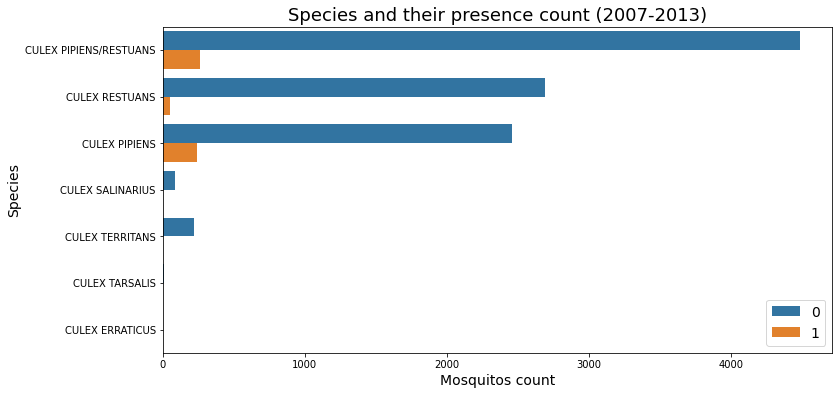

In [ ]:
# visualizing species, count and virus presence
plt.figure(figsize=(12,6))
sns.countplot(y='Species', hue='WnvPresent', data=train, orient='h')
plt.title('Species and their presence count (2007-2013)', fontsize=18)
plt.xlabel('Mosquitos count', fontsize=14)
plt.ylabel('Species', fontsize=14)
plt.legend(loc='lower right', fontsize=14);
# the three species detected with virus are in orange

**The plot shows the mosquito count for each species and if they carry the West Nile Virus. From the plot, it seems that PIPENS AND RESTUANS are the most common species that carry the virus and they also had the highest population concentration among the species.**

### Trap

In [ ]:
train.Trap.unique() # nothing special but some with alphabet suffix, need to decide what to do with these

array(['T002', 'T007', 'T015', 'T045', 'T046', 'T048', 'T049', 'T050',
       'T054', 'T086', 'T091', 'T094', 'T096', 'T129', 'T143', 'T148',
       'T153', 'T159', 'T009', 'T011', 'T016', 'T019', 'T025', 'T028',
       'T031', 'T033', 'T089', 'T090', 'T092', 'T135', 'T141', 'T142',
       'T145', 'T146', 'T147', 'T149', 'T150', 'T151', 'T152', 'T154',
       'T158', 'T162', 'T218', 'T220', 'T001', 'T003', 'T006', 'T008',
       'T012', 'T034', 'T037', 'T040', 'T043', 'T047', 'T051', 'T085',
       'T088', 'T161', 'T219', 'T013', 'T014', 'T018', 'T030', 'T084',
       'T144', 'T160', 'T005', 'T017', 'T044', 'T095', 'T004', 'T035',
       'T036', 'T039', 'T060', 'T061', 'T062', 'T065', 'T066', 'T067',
       'T069', 'T070', 'T071', 'T073', 'T074', 'T075', 'T076', 'T077',
       'T079', 'T080', 'T081', 'T082', 'T083', 'T114', 'T155', 'T063',
       'T115', 'T138', 'T200', 'T206', 'T209', 'T212', 'T215', 'T107',
       'T128', 'T072', 'T078', 'T097', 'T099', 'T100', 'T102', 'T103',
      

**Some traps are "satellite traps". These are traps that are set up near an established trap to enhance surveillance efforts (usually within 6 blocks). Satellite traps are postfixed with letters.**

**For example, T220A is a satellite trap to T220.**

In [ ]:
# viewing
train[(train['Trap'] == 'T094') | (train['Trap'] == 'T094B')]

Date                                        Address  \
16    2007-05-29  1700 West 95th Street, Chicago, IL 60643, USA   
42    2007-06-05  1700 West 95th Street, Chicago, IL 60643, USA   
304   2007-07-11  1700 West 95th Street, Chicago, IL 60643, USA   
835   2007-08-01  1700 West 95th Street, Chicago, IL 60643, USA   
836   2007-08-01  1700 West 95th Street, Chicago, IL 60643, USA   
...          ...                                            ...   
10176 2013-09-12  1700 West 95th Street, Chicago, IL 60643, USA   
10177 2013-09-12  1700 West 95th Street, Chicago, IL 60643, USA   
10312 2013-09-19  1700 West 95th Street, Chicago, IL 60643, USA   
10313 2013-09-19  1700 West 95th Street, Chicago, IL 60643, USA   
10421 2013-09-26  1700 West 95th Street, Chicago, IL 60643, USA   

                      Species Block      Street  Trap  \
16             CULEX RESTUANS    17   W 95TH ST  T094   
42     CULEX PIPIENS/RESTUANS    17   W 95TH ST  T094   
304    CULEX PIPIENS/RESTUANS    17   W 95TH ST  T094   
835    CULEX PIPIENS/RESTUANS    17   W 95TH ST  T094   
836            CULEX RESTUANS    17   W 95TH ST  T094   
...                       ...   ...         ...   ...   
10176  CULEX PIPIENS/RESTUANS    17   W 95TH ST  T094   
10177           CULEX PIPIENS    17   W 95TH ST  T094   
10312  CULEX PIPIENS/RESTUANS    17   W 95TH ST  T094   
10313           CULEX PIPIENS    17   W 95TH ST  T094   
10421  CULEX PIPIENS/RESTUANS    17   W 95TH ST  T094   

             AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
16     1700  W 95TH ST, Chicago, IL  41.720848 -87.666014                9   
42     1700  W 95TH ST, Chicago, IL  41.720848 -87.666014                9   
304    1700  W 95TH ST, Chicago, IL  41.720848 -87.666014                9   
835    1700  W 95TH ST, Chicago, IL  41.720848 -87.666014                9   
836    1700  W 95TH ST, Chicago, IL  41.720848 -87.666014                9   
...                             ...        ...        ...              ...   
10176  1700  W 95TH ST, Chicago, IL  41.720848 -87.666014                9   
10177  1700  W 95TH ST, Chicago, IL  41.720848 -87.666014                9   
10312  1700  W 95TH ST, Chicago, IL  41.720848 -87.666014                9   
10313  1700  W 95TH ST, Chicago, IL  41.720848 -87.666014                9   
10421  1700  W 95TH ST, Chicago, IL  41.720848 -87.666014                9   

       NumMosquitos  WnvPresent  Year  Month  Week  Day  \
16                3           0  2007      5    22   29   
42                2           0  2007      6    23    5   
304               1           0  2007      7    28   11   
835               3           0  2007      8    31    1   
836               1           0  2007      8    31    1   
...             ...         ...   ...    ...   ...  ...   
10176            10           0  2013      9    37   12   
10177             4           0  2013      9    37   12   
10312             3           0  2013      9    38   19   
10313             8           0  2013      9    38   19   
10421            12           0  2013      9    39   26   

                      location  
16     (41.720848, -87.666014)  
42     (41.720848, -87.666014)  
304    (41.720848, -87.666014)  
835    (41.720848, -87.666014)  
836    (41.720848, -87.666014)  
...                        ...  
10176  (41.720848, -87.666014)  
10177  (41.720848, -87.666014)  
10312  (41.720848, -87.666014)  
10313  (41.720848, -87.666014)  
10421  (41.720848, -87.666014)  

[126 rows x 17 columns]

In [ ]:
# counting
print(train[train['Trap']=='T094B'].count())
print(train[train['Trap']=='T054C'].count())

Date                      5
Address                   5
Species                   5
Block                     5
Street                    5
Trap                      5
AddressNumberAndStreet    5
Latitude                  5
Longitude                 5
AddressAccuracy           5
NumMosquitos              5
WnvPresent                5
Year                      5
Month                     5
Week                      5
Day                       5
location                  5
dtype: int64
Date                      9
Address                   9
Species                   9
Block                     9
Street                    9
Trap                      9
AddressNumberAndStreet    9
Latitude                  9
Longitude                 9
AddressAccuracy           9
NumMosquitos              9
WnvPresent                9
Year                      9
Month                     9
Week                      9
Day                       9
location                  9
dtype: int64


**In total there are only 14 rows and there are multiple mother rows in the same day. Thus, if we combine with the mother trap id it will be impossible to determine which mother row to merge with. Some mother rows are WnvPresent=0 while child WnvPresent=1, so it will be wrong if we merged them.**

**In addition, Address, lat/long variables of mother rows are different from child trap. Thus, we shall not merge these child and mother traps, just treat them as individual traps.**

### NumMosquitos

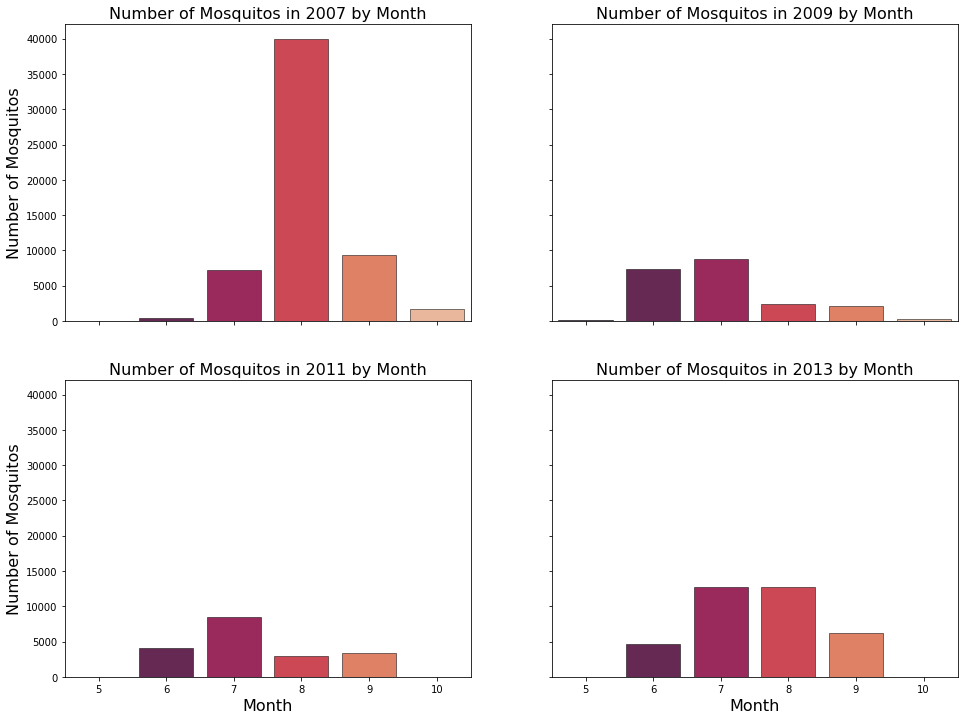

In [ ]:
# visualizing mos count by year by month
mos_count = train[['Date', 'Year', 'Month', 'NumMosquitos', 'WnvPresent']]
order = mos_count.Month.unique().tolist()

fig, axes = plt.subplots(2,2, figsize=(16,12), facecolor='white', sharex=True, sharey=True)
sns.barplot(x='Month', y='NumMosquitos', data=mos_count[mos_count['Year']==2007][['Month', 'NumMosquitos', 'WnvPresent']],
            palette='rocket', edgecolor='black', linewidth=0.5, ci=None, estimator=sum, ax=axes[0,0],
            order=order);
axes[0,0].set_title('Number of Mosquitos in 2007 by Month', fontsize=16)
axes[0,0].set_xlabel('', fontsize=16)
axes[0,0].set_ylabel('Number of Mosquitos', fontsize=16);

sns.barplot(x='Month', y='NumMosquitos', data=mos_count[mos_count['Year']==2009][['Month', 'NumMosquitos', 'WnvPresent']],
            palette='rocket', edgecolor='black', linewidth=0.5, ci=None, estimator=sum, ax=axes[0,1],
            order=order);
axes[0,1].set_title('Number of Mosquitos in 2009 by Month', fontsize=16)
axes[0,1].set_xlabel('', fontsize=16)
axes[0,1].set_ylabel('', fontsize=16);

sns.barplot(x='Month', y='NumMosquitos', data=mos_count[mos_count['Year']==2011][['Month', 'NumMosquitos', 'WnvPresent']],
            palette='rocket', edgecolor='black', linewidth=0.5, ci=None, estimator=sum, ax=axes[1,0],
            order=order);
axes[1,0].set_title('Number of Mosquitos in 2011 by Month', fontsize=16)
axes[1,0].set_xlabel('Month', fontsize=16)
axes[1,0].set_ylabel('Number of Mosquitos', fontsize=16);

sns.barplot(x='Month', y='NumMosquitos', data=mos_count[mos_count['Year']==2013][['Month', 'NumMosquitos', 'WnvPresent']],
            palette='rocket', edgecolor='black', linewidth=0.5, ci=None, estimator=sum, ax=axes[1,1],
            order=order);
axes[1,1].set_title('Number of Mosquitos in 2013 by Month', fontsize=16)
axes[1,1].set_xlabel('Month', fontsize=16)
axes[1,1].set_ylabel('', fontsize=16);

In [ ]:
mos_count.groupby(['Month'])['NumMosquitos'].sum()

Month
5       230
6     16578
7     37248
8     58036
9     21029
10     1918
Name: NumMosquitos, dtype: int64

**Mosquitos populations increase during the warmer months between July and Sep across 2007 to 2013 (odd years data only)**

**2007 and 2013 appears to had the highest mosquitos population among the odd years.**

In [ ]:
# mosquitos hotspots by AddressNumberAndStreet where WnvPresent=1
train[train['WnvPresent']==1].groupby('AddressNumberAndStreet')['NumMosquitos'].sum().sort_values(ascending=False).head(10)

AddressNumberAndStreet
1000  W OHARE AIRPORT, Chicago, IL       2060
1200  S DOTY AVE, Chicago, IL            1878
1000  S STONY ISLAND AVE, Chicago, IL     759
4100  N OAK PARK AVE, Chicago, IL         500
2400  E 105TH ST, Chicago, IL             482
4600  N MILWAUKEE AVE, Chicago, IL        380
7000  N MOSELL AVE, Chicago, IL           330
4200  W 127TH PL, Chicago, IL             316
6100  W FULLERTON AVE, Chicago, IL        316
1000  N CENTRAL PARK DR, Chicago, IL      313
Name: NumMosquitos, dtype: int64

**The top 10 addresses where Wnv was detected and with the highest cumulative population of mosquitoes are as shown. Since NumMosquitos is not a feature in the test data set, we cannot use this as a predictor in the model. However, we can see if the number of mosquitos actually reduces after a spray is done. We will explore this in the EDA for spray data set.**

### WnVPresent

In [ ]:
train.WnvPresent.unique()

array([0, 1], dtype=int64)

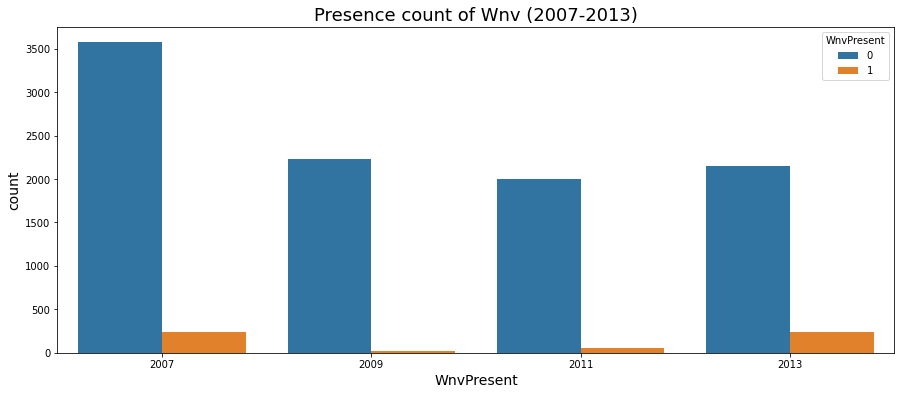

In [ ]:
# visualizing the total count of virus=1 between 2007 to 2013
plt.figure(figsize=(15,6))
sns.countplot(x='Year', hue='WnvPresent', data=train)
plt.title('Presence count of Wnv (2007-2013)', fontsize=18);
plt.xlabel('WnvPresent', fontsize=14)
plt.ylabel('count', fontsize=14);

In [ ]:
train.WnvPresent.value_counts(normalize=True)

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

**From the train data, there is an imbalanced distribution of records where WnvPresent was detected as 0(no) vs 1(yes). This is likely to lead to a skew representation in the model and will need to be look at during pre-processing. Under/Over sampling and SMOTE could be employed to address this imbalance.**

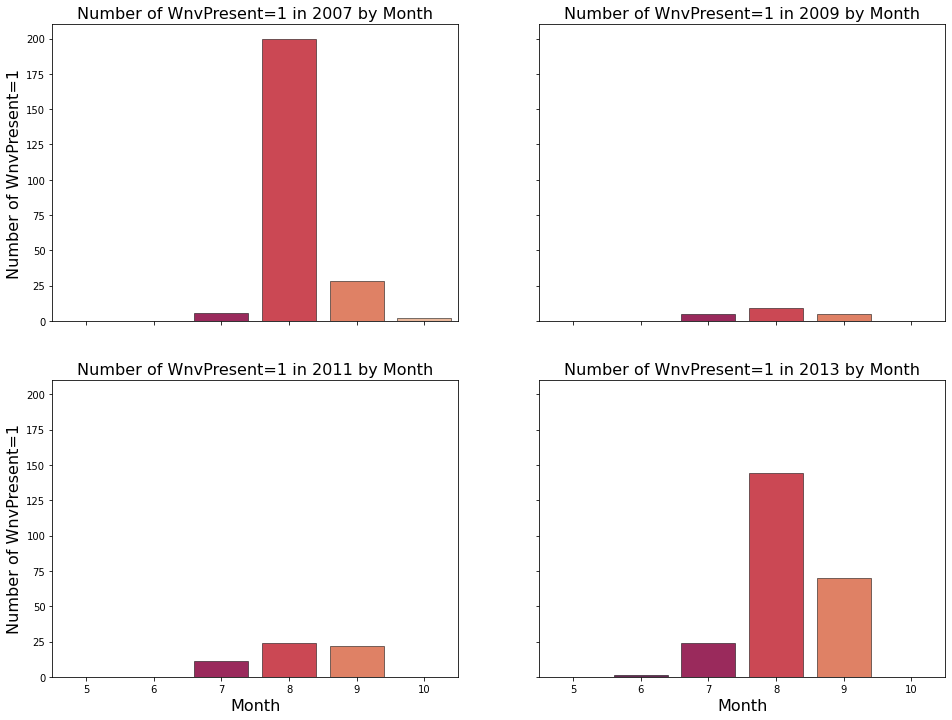

In [ ]:
# visualizing virus count by year by month
NumMosquitos_Yr = train[['Date', 'Year', 'Month', 'NumMosquitos', 'WnvPresent']]
order = NumMosquitos_Yr.Month.unique().tolist()

fig, axes = plt.subplots(2,2, figsize=(16,12), facecolor='white', sharex=True, sharey=True)

sns.barplot(x='Month', y='WnvPresent',
            data=NumMosquitos_Yr[NumMosquitos_Yr['Year']==2007][['Month', 'NumMosquitos', 'WnvPresent']],
            palette='rocket', edgecolor='black', linewidth=0.5, ci=None, estimator=sum, ax=axes[0,0],
            order=order);
axes[0,0].set_title('Number of WnvPresent=1 in 2007 by Month', fontsize=16)
axes[0,0].set_xlabel('', fontsize=16)
axes[0,0].set_ylabel('Number of WnvPresent=1', fontsize=16);

sns.barplot(x='Month', y='WnvPresent',
            data=NumMosquitos_Yr[NumMosquitos_Yr['Year']==2009][['Month', 'NumMosquitos', 'WnvPresent']],
            palette='rocket', edgecolor='black', linewidth=0.5, ci=None, estimator=sum, ax=axes[0,1],
            order=order);
axes[0,1].set_title('Number of WnvPresent=1 in 2009 by Month', fontsize=16)
axes[0,1].set_xlabel('', fontsize=16)
axes[0,1].set_ylabel('', fontsize=16);

sns.barplot(x='Month', y='WnvPresent',
            data=NumMosquitos_Yr[NumMosquitos_Yr['Year']==2011][['Month', 'NumMosquitos', 'WnvPresent']],
            palette='rocket', edgecolor='black', linewidth=0.5, ci=None, estimator=sum, ax=axes[1,0],
            order=order);
axes[1,0].set_title('Number of WnvPresent=1 in 2011 by Month', fontsize=16)
axes[1,0].set_xlabel('Month', fontsize=16)
axes[1,0].set_ylabel('Number of WnvPresent=1', fontsize=16);

sns.barplot(x='Month', y='WnvPresent',
            data=NumMosquitos_Yr[NumMosquitos_Yr['Year']==2013][['Month', 'NumMosquitos', 'WnvPresent']],
            palette='rocket', edgecolor='black', linewidth=0.5, ci=None, estimator=sum, ax=axes[1,1],
            order=order);
axes[1,1].set_title('Number of WnvPresent=1 in 2013 by Month', fontsize=16)
axes[1,1].set_xlabel('Month', fontsize=16)
axes[1,1].set_ylabel('', fontsize=16);

**WnvPresent=1 count increase during the warmer months between July and Sep across 2007 to 2013 (odd years data only)**

**2007 and 2013 appears to had the highest cases of WnvPresent=1 among the odd years.**

**This trend was in-line with the higher mosquitos population in the same year and months.**

## Test.csv

Generally, in test data we will apply the same treatment as in train data. Here we will quickly go through the same EDA process to see if there is any significant findings that require different actions.

### General overview

In [ ]:
test.columns

Index(['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'Year', 'Month', 'Week', 'Day'],
      dtype='object')

In [ ]:
test.Id.unique() # nothing special can drop

array([     1,      2,      3, ..., 116291, 116292, 116293], dtype=int64)

In [ ]:
test['Date'].describe(datetime_is_numeric=True)

count                           116293
mean     2011-04-18 11:49:09.546180352
min                2008-06-11 00:00:00
25%                2008-09-19 00:00:00
50%                2010-09-02 00:00:00
75%                2012-08-30 00:00:00
max                2014-10-02 00:00:00
Name: Date, dtype: object

**Date range of test.csv is from 2008-06-11 to 2014-10-02. Only even years data in test.csv**

### Address, Block, Street, AddressNumberAndStreet

In [ ]:
test.Address.unique()
# several addresses missing the 4digits numbers infront,
# suggest to drop since there is another column 'AddressNumberAndStreet' that is a more complete string
# plus we are likely to use long/lat instead of an address. Keeping for now.

array(['4100 North Oak Park Avenue, Chicago, IL 60634, USA',
       '6200 North Mandell Avenue, Chicago, IL 60646, USA',
       '7900 West Foster Avenue, Chicago, IL 60656, USA',
       '1500 West Webster Avenue, Chicago, IL 60614, USA',
       '2500 West Grand Avenue, Chicago, IL 60654, USA',
       '1100 Roosevelt Road, Chicago, IL 60608, USA',
       '1100 West Chicago Avenue, Chicago, IL 60642, USA',
       '2100 North Stave Street, Chicago, IL 60647, USA',
       '2200 North Cannon Drive, Chicago, IL 60614, USA',
       '2200 West 113th Street, Chicago, IL 60643, USA',
       '1100 South Peoria Street, Chicago, IL 60608, USA',
       '1700 West 95th Street, Chicago, IL 60643, USA',
       '2200 West 89th Street, Chicago, IL 60643, USA',
       'North Streeter Drive, Chicago, IL 60611, USA',
       '6500 North Oak Park Avenue, Chicago, IL 60631, USA',
       '7500 North Oakley Avenue, Chicago, IL 60645, USA',
       '1500 North Long Avenue, Chicago, IL 60651, USA',
       '8900 Sou

In [ ]:
test.Block.unique()
# several addresses missing the 4digits numbers infront,
# suggest to drop since there is another column 'AddressNumberAndStreet' that is a more complete string
# plus we are likely to use long/lat instead of an address. Keeping for now.

array([41, 62, 79, 15, 25, 11, 21, 22, 17, 53, 65, 75, 89, 91, 36, 72, 38,
       49, 58, 50, 14, 10, 42, 40, 43, 28, 18, 70, 35, 93, 37, 45, 46, 60,
       61, 27, 68, 30, 96, 64, 12, 20, 33, 52, 67, 73, 39, 47, 55, 71, 77,
       63, 13, 81, 24, 80, 82, 98, 66, 26, 29, 48, 51, 90, 34],
      dtype=object)

In [ ]:
test.Street.unique()
# several addresses missing the 4digits numbers infront,
# suggest to drop since there is another column 'AddressNumberAndStreet' that is a more complete string
# plus we are likely to use long/lat instead of an address. Keeping for now.

array([' N OAK PARK AVE', ' N MANDELL AVE', ' W FOSTER AVE',
       ' W WEBSTER AVE', ' W GRAND AVE', ' W ROOSEVELT', ' W CHICAGO',
       ' N STAVE ST', ' N CANNON DR', ' W 113TH ST', ' S PEORIA ST',
       ' W 95TH ST', ' W 89TH ST', ' N STREETER DR', ' N OAKLEY AVE',
       ' N LONG AVE', ' S CARPENTER ST', ' W HIGGINS AVE',
       ' N PITTSBURGH AVE', ' N OKETO AVE', ' N CALIFORNIA AVE',
       ' W BALMORAL AVE', ' N WESTERN AVE', ' S CENTRAL AVE',
       ' N HUMBOLDT DR', ' S VINCENNES', ' S ASHLAND AVE', ' S STATE ST',
       ' W 127TH PL', ' W AGATITE AVE', ' N AUSTIN AVE',
       ' N ASHLAND AVE OVERPASS', ' N RICHMOND ST', ' N FRANCISCO AVE',
       ' W GRANVILLE AVE', ' W FARWELL AVE', '  W ARMITAGE AVENUE',
       ' S MILLARD AVE', ' N LAWLER AVE', ' W 116TH ST',
       ' S DR MARTIN LUTHER KING JR DR', ' N KEDVALE AVE',
       ' N CAMPBELL AVE', ' N TRIPP AVE', ' N MILWAUKEE AVE',
       ' N AVONDALE AVE', ' N MOSELL AVE', ' N LEMONT AVE',
       ' S WESTERN AVE', ' W BELDE

In [ ]:
test.AddressNumberAndStreet.unique()
# several addresses missing the 4digits numbers infront,
# suggest to drop since there is another column 'AddressNumberAndStreet' that is a more complete string
# plus we are likely to use long/lat instead of an address. Keeping for now.

array(['4100  N OAK PARK AVE, Chicago, IL',
       '6200  N MANDELL AVE, Chicago, IL',
       '7900  W FOSTER AVE, Chicago, IL',
       '1500  W WEBSTER AVE, Chicago, IL',
       '2500  W GRAND AVE, Chicago, IL', '1100  W ROOSEVELT, Chicago, IL',
       '1100  W CHICAGO, Chicago, IL', '2100  N STAVE ST, Chicago, IL',
       '2200  N CANNON DR, Chicago, IL', '2200  W 113TH ST, Chicago, IL',
       '1100  S PEORIA ST, Chicago, IL', '1700  W 95TH ST, Chicago, IL',
       '2200  W 89TH ST, Chicago, IL', '5300  N STREETER DR, Chicago, IL',
       '6500  N OAK PARK AVE, Chicago, IL',
       '7500  N OAKLEY AVE, Chicago, IL', '1500  N LONG AVE, Chicago, IL',
       '8900  S CARPENTER ST, Chicago, IL',
       '9100  W HIGGINS AVE, Chicago, IL',
       '3600  N PITTSBURGH AVE, Chicago, IL',
       '7200  N OKETO AVE, Chicago, IL',
       '3800  N CALIFORNIA AVE, Chicago, IL',
       '4900  W BALMORAL AVE, Chicago, IL',
       '5800  N WESTERN AVE, Chicago, IL',
       '5000  S CENTRAL AVE, Chic

### Address Accuracy, Longitude and Latitude

In [ ]:
test.AddressAccuracy.unique() # nothing special but keeping for now

array([9, 8, 5, 3], dtype=int64)

In [ ]:
test[['AddressAccuracy', 'Longitude', 'Latitude']].describe()

AddressAccuracy      Longitude       Latitude
count    116293.000000  116293.000000  116293.000000
mean          7.954357     -87.693658      41.849389
std           1.252733       0.080699       0.106593
min           3.000000     -87.930995      41.644612
25%           8.000000     -87.750938      41.753411
50%           8.000000     -87.694991      41.862292
75%           9.000000     -87.648860      41.951866
max           9.000000     -87.531635      42.017430

**Address Accuracy is an ordinal indicator of accuracy of addresses according to the accuracy of the Longitude and Latitude values. As it is not clear if these will be useful features to consider, we shall leave it for now.**

**Since Longitude and Latitude come in pairs, it will be better to have a feature engineered column that combine them for easy referencing.**

In [ ]:
# combined and making a new column
test['location'] = list(zip(test.Latitude, test.Longitude))
test.head(2)

Id       Date                                            Address  \
0   1 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1   2 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS    41   N OAK PARK AVE  T002   
1          CULEX RESTUANS    41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   

   Year  Month  Week  Day                location  
0  2008      6    24   11  (41.95469, -87.800991)  
1  2008      6    24   11  (41.95469, -87.800991)

### Species

**A total of 8 species groups of mosquitos are found in the traps. They are PIPIENS/RESTUANS, PIPIENS, RESTUANS, TERRITANS, SALINARIUS, TARSALIS, ERRATICUS and UNSPECIFIED CULEX.**

In [ ]:
test.Species.unique()
# 'UNSPECIFIED CULEX' cannot drop or impute cos in test

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'UNSPECIFIED CULEX', 'CULEX ERRATICUS'], dtype=object)

In [ ]:
test.Species.value_counts() # 'UNSPECIFIED CULEX' is 14345/116293 = 12.3% rows

CULEX PIPIENS/RESTUANS    15359
CULEX RESTUANS            14670
CULEX PIPIENS             14521
CULEX SALINARIUS          14355
CULEX TERRITANS           14351
CULEX TARSALIS            14347
CULEX ERRATICUS           14345
UNSPECIFIED CULEX         14345
Name: Species, dtype: int64

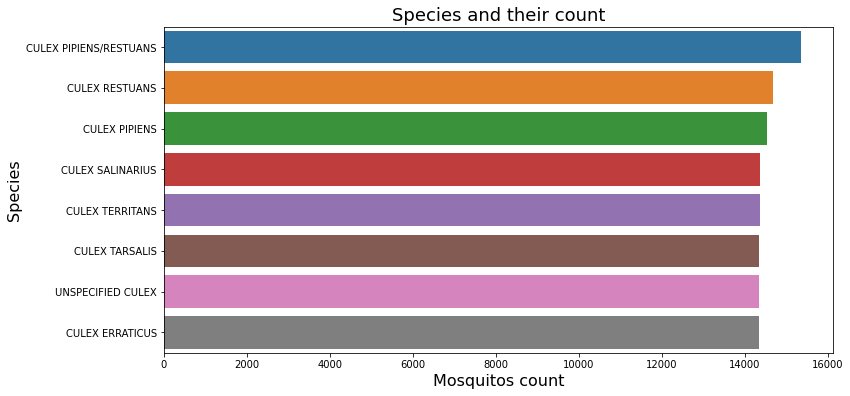

In [ ]:
# visualizing mos count by species
plt.figure(figsize=(12,6))
sns.countplot(y='Species', data=test, orient='h')
plt.title('Species and their count', fontsize=18)
plt.xlabel('Mosquitos count', fontsize=16)
plt.ylabel('Species', fontsize=16);

**It is unclear at this point what treatment will be necessary for the UNSPECIFIED CULEX group. However, it constitutes 14345/116293 = 12.3% of rows in test.csv. We will keep this for now.**

### Trap

In [ ]:
test.Trap.unique() # nothing special but some with alphabet suffix, need to decide what to do with these

array(['T002', 'T007', 'T015', 'T045', 'T046', 'T048', 'T049', 'T050',
       'T054', 'T086', 'T091', 'T094', 'T096', 'T129', 'T143', 'T148',
       'T153', 'T159', 'T009', 'T011', 'T016', 'T019', 'T025', 'T028',
       'T031', 'T033', 'T089', 'T090', 'T092', 'T135', 'T141', 'T142',
       'T145', 'T146', 'T147', 'T149', 'T150', 'T151', 'T152', 'T154',
       'T158', 'T162', 'T218', 'T220', 'T001', 'T003', 'T006', 'T008',
       'T012', 'T034', 'T037', 'T040', 'T043', 'T047', 'T051', 'T085',
       'T088', 'T161', 'T219', 'T013', 'T014', 'T018', 'T030', 'T084',
       'T144', 'T160', 'T005', 'T017', 'T044', 'T095', 'T004', 'T035',
       'T036', 'T039', 'T060', 'T061', 'T062', 'T065', 'T066', 'T067',
       'T069', 'T070', 'T071', 'T073', 'T074', 'T075', 'T076', 'T077',
       'T079', 'T080', 'T081', 'T082', 'T083', 'T114', 'T155', 'T063',
       'T115', 'T138', 'T200', 'T206', 'T209', 'T212', 'T215', 'T107',
       'T128', 'T072', 'T078', 'T097', 'T099', 'T100', 'T102', 'T103',
      

**Since it was decided that we will treat satellite traps as individual trap, the same treatment shall be applied to test.csv. Thus, nothing to change here.**

## Spray.csv

### General overview

In [ ]:
spray.columns

Index(['Date', 'Time', 'Latitude', 'Longitude', 'Year', 'Month', 'Week',
       'Day'],
      dtype='object')

In [ ]:
spray['Date'].describe(datetime_is_numeric=True)

count                            14294
mean     2013-05-21 07:22:57.641011712
min                2011-08-29 00:00:00
25%                2013-07-17 00:00:00
50%                2013-08-15 00:00:00
75%                2013-08-22 00:00:00
max                2013-09-05 00:00:00
Name: Date, dtype: object

In [ ]:
print(spray['Date'].nunique())
spray['Date'].unique()

10


array(['2011-08-29T00:00:00.000000000', '2011-09-07T00:00:00.000000000',
       '2013-07-17T00:00:00.000000000', '2013-07-25T00:00:00.000000000',
       '2013-08-08T00:00:00.000000000', '2013-08-15T00:00:00.000000000',
       '2013-08-16T00:00:00.000000000', '2013-08-22T00:00:00.000000000',
       '2013-08-29T00:00:00.000000000', '2013-09-05T00:00:00.000000000'],
      dtype='datetime64[ns]')

**Date range of spray.csv is from 2011-08-29 to 2013-09-05. Only two years of data.**

**Only 10 unique spray dates meaning only 10 sprays were done between 2011 and 2013**

In [ ]:
spray.Time.unique()

array([datetime.time(18, 56, 58), datetime.time(18, 57, 8),
       datetime.time(18, 57, 18), ..., datetime.time(20, 4, 1),
       datetime.time(20, 4, 11), datetime.time(20, 4, 21)], dtype=object)

**All the sprays are done between 18.56pm to 20.04pm**

### Longitude and Latitude

In [ ]:
# combined and making a new column
spray['location'] = list(zip(spray.Latitude, spray.Longitude))
spray.head(2)

Date      Time   Latitude  Longitude  Year  Month  Week  Day  \
0 2011-08-29  18:56:58  42.391623 -88.089163  2011      8    35   29   
1 2011-08-29  18:57:08  42.391348 -88.089163  2011      8    35   29   

                                location  
0  (42.3916233333333, -88.0891633333333)  
1  (42.3913483333333, -88.0891633333333)

**Since Longitude and Latitude come in pairs, it will be better to have a feature engineered column that combine them for easy referencing.**

## Visualizing locations

### Weather stations

There are 2 weather stations reporting the weather data set.

In [ ]:
# locations of ASOS/AWOS stations
weather_stn = pd.DataFrame({'name' : ['Stn 1 - Chicago O’Hare International Airport', 'Stn 2 - Chicago Midway International Airport'],
               'Longitude' : [-87.933, -87.752],
               'Latitude' : [41.995, 41.786]})
weather_stn

name  Longitude  Latitude
0  Stn 1 - Chicago O’Hare International Airport    -87.933    41.995
1  Stn 2 - Chicago Midway International Airport    -87.752    41.786

### Traps locations

Traps locations are denominated by their geographical coordinates (longitude , latitude).

 No of trap locations = 138


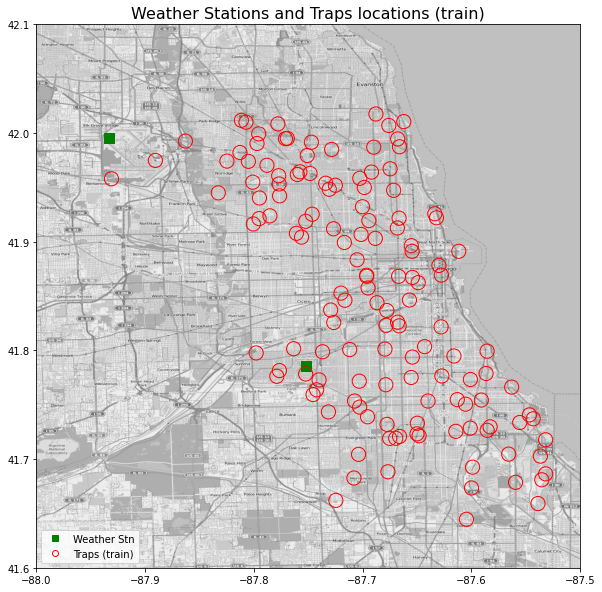

In [ ]:
# getting map data
mapdata = np.loadtxt("assets/mapdata_copyright_openstreetmap_contributors.txt")

# set boundaries
origin = [41.6, -88]              # lat/long of origin (lower left corner)
upperRight = [42.1, -87.5]          # lat/long of upper right corner

# generate plot
plt.figure(figsize=(10,10), facecolor='white')
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])

# weather stn
for lg, lt in zip(weather_stn['Longitude'], weather_stn['Latitude']):
    plt.scatter(x=lg, y=lt, c='g', marker='s', s=120)

# traps locations
traps_loc = train[['Longitude', 'Latitude']].drop_duplicates(inplace=False)
print(' No of trap locations =', traps_loc.value_counts().sum())
for lg, lt in zip(traps_loc['Longitude'], traps_loc['Latitude']):
    plt.scatter(x=lg, y=lt, marker='o', facecolors='none', edgecolors='r', s=200)
    
plt.title('Weather Stations and Traps locations (train)', fontsize = 16)

#custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='g', marker='s', lw=0, label='Weather Stn'),
                   Line2D([0], [0], color='r', marker='o', lw=0, label='Traps (train)', fillstyle='none')]

plt.legend(handles=legend_elements, loc='lower left')

plt.xlim(-88, -87.5)
plt.ylim(41.6, 42.1);

### Spray locations

**There are over 14k spray locations in the spray data set. They are similarly denominated by their geographical coordinates.**

In [ ]:
# finding no of spray locations
spray_loc = spray[['Longitude', 'Latitude']].drop_duplicates(inplace=False)
print(' No of spray locations =', spray_loc.value_counts().sum())

 No of spray locations = 14294


**14,294 spray locations will be too much to meaningfully visualize on the map. It will also be very hard to determine where would be the good locations to recommend spray operations. Thus, we will use DBSCAN and specify a clustering distance in meters to logically reduce the 14,294 sprays locations into an interpretable parameter.**

In [ ]:
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

# convert the long/lat into radians for use with metric 'haversine' in dbscan
coords = spray_loc[['Latitude', 'Longitude']].values
coords

array([[ 42.39162333, -88.08916333],
       [ 42.39134833, -88.08916333],
       [ 42.39102167, -88.08915667],
       ...,
       [ 42.00602167, -87.81739167],
       [ 42.00545333, -87.81742333],
       [ 42.004805  , -87.81746   ]])

**After trying various clustering distance in meters, we settled on 100m as it gave a positive Silhouette score and a reasonable number of clusters at 145. Any other bigger distances would return too many number of clusters. Below is the DBSCAN clustering process.**

In [ ]:
# metric conversion factor
kms_per_radian = 6371.0088

# range to consider for clustering
meter_range = 100
print('Cluster range (m) :', meter_range)

# convert clustering range to epsilon equivalent
epsilon = meter_range/1000/ kms_per_radian

# instantiate dbscan
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine')
# The epsilon parameter is the max distance that points can be from each other to be considered a cluster.
# The min_samples parameter is the minimum cluster size. Set min_samples to 1 so that every data point gets assigned
# to either a cluster or forms its own cluster of 1. Nothing will be classified as noise.
# Using haversine metric and ball tree algorithm to calculate great circle distances between points.

# fit data
db.fit(np.radians(coords))
# Notice epsilon and coordinates get converted to radians, because scikit-learn’s haversine metric needs radian units

# retrieve labels and print number of clusters
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

# print the summary
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression'
print(message.format(len(spray_loc), num_clusters, 100*(1 - float(num_clusters) / len(spray_loc))))
print('Silhouette coefficient: {:0.03f}'.format(silhouette_score(coords, cluster_labels)))

Cluster range (m) : 100
Number of clusters: 145
Clustered 14,294 points down to 145 clusters, for 99.0% compression
Silhouette coefficient: 0.025


**The points in each cluster are spread (within the range specified) in spartial sense, we shall use the 'shapely' package's 'MultiPoint' function to determine the most centralized points within each cluster (i.e point in each cluster that is closest to its centroid).** 

In [ ]:
# turn the clusters into a pandas series, where each element is a cluster of points
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])
print(len(clusters))
clusters

145


0      [[42.3916233333333, -88.0891633333333], [42.39...
1      [[41.9814333333333, -87.7877766666667], [41.98...
2      [[41.975373333333295, -87.78783666666669], [41...
3      [[41.982766666666706, -87.7881916666667], [41....
4      [[41.9977283333333, -87.7675316666667], [41.99...
                             ...                        
140    [[41.977723333333294, -87.6930433333333], [41....
141    [[41.976783333333294, -87.68961999999999], [41...
142    [[41.991234999999996, -87.6770466666667], [41....
143    [[41.997975, -87.7909116666667], [41.99857, -8...
144    [[41.9809333333333, -87.8455483333333], [41.98...
Length: 145, dtype: object

In [ ]:
# define a function to get the centroid of the cluster
# The function first calculates the centroid’s coordinates, then use min function to find the smallest member
# of the cluster in terms of distance to that centroid. The key argument does this with a lambda function that
# calculates each point’s distance to the centroid in meters via geopy’s great circle function.
# Then return the coordinates of the point that was the least distance from the centroid.
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

# call and map the function to pandas series of clusters.
# i.e. for each cluster in the series, get the center-most point and then assembles all these points into
# a new series called centermost_points
centermost_points = clusters.map(get_centermost_point)
centermost_points

0        (42.3921833333333, -88.0937666666667)
1        (41.9793516666667, -87.7877533333333)
2      (41.973851666666704, -87.7967833333333)
3        (41.9856518944139, -87.8146391549338)
4       (42.00538833333329, -87.7732683333333)
                        ...                   
140      (41.9776966666667, -87.6957433333333)
141             (41.9848416666667, -87.680655)
142    (41.992236666666706, -87.6770766666667)
143      (42.0080316666667, -87.8103666666667)
144    (41.979158333333295, -87.8424066666667)
Length: 145, dtype: object

In [ ]:
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'Longitude':lons, 'Latitude':lats})
rep_points.tail()

Longitude   Latitude
140 -87.695743  41.977697
141 -87.680655  41.984842
142 -87.677077  41.992237
143 -87.810367  42.008032
144 -87.842407  41.979158

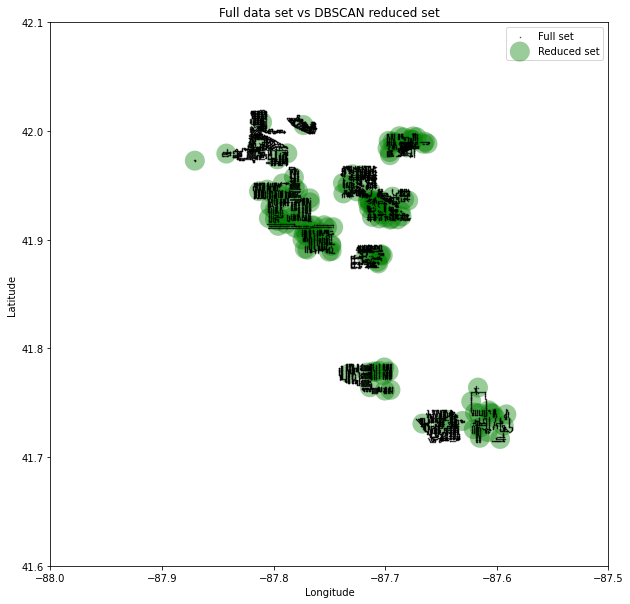

In [ ]:
# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[10, 10], facecolor='w')
#rs_scatter = ax.scatter(rs['Longitude'], rs['Latitude'], c='g', edgecolor='None', alpha=0.4, s=400)
rs_scatter = ax.scatter(rep_points['Longitude'], rep_points['Latitude'], c='g', edgecolor='None', alpha=0.4, s=400)

spray_loc_scatter = ax.scatter(spray_loc['Longitude'], spray_loc['Latitude'], c='k', alpha=0.8, s=0.2)

ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([spray_loc_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')

plt.xlim(-88, -87.5)
plt.ylim(41.6, 42.1);
plt.show()

**We can see the 145 representative spray clusters, in green, approximating the spatial distribution of the 14,294 spray points of the spray data set, in black. DBSCAN reduced the data by 99%, from 14,294 points to 145 points. There are little to no gaps in the reduced data set and spray locations are no longer drastically over-represented.**

**Next we overlay the clustered spray locations onto the map to visualize its representation.**

 No of trap locations = 138
 No of clustered spray locations (100m range) = 145


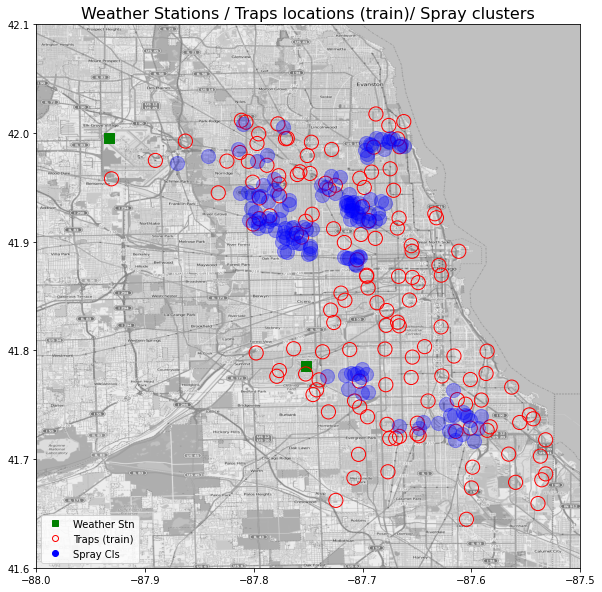

In [ ]:
# getting map data
mapdata = np.loadtxt("assets/mapdata_copyright_openstreetmap_contributors.txt")

# set boundaries
origin = [41.6, -88]              # lat/long of origin (lower left corner)
upperRight = [42.1, -87.5]          # lat/long of upper right corner

# generate plot
plt.figure(figsize=(10,10))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])

# weather stn
for lg, lt in zip(weather_stn['Longitude'], weather_stn['Latitude']):
    plt.scatter(x=lg, y=lt, c='g', marker='s', s=120)

# traps locations
traps_loc = train[['Longitude', 'Latitude']].drop_duplicates(inplace=False)
print(' No of trap locations =', traps_loc.value_counts().sum())
for lg, lt in zip(traps_loc['Longitude'], traps_loc['Latitude']):
    plt.scatter(x=lg, y=lt, marker='o', facecolors='none', edgecolors='r', s=200)

# DBSCAN clustered spray locations
dbs_spray = rep_points[['Longitude', 'Latitude']]
print(' No of clustered spray locations (100m range) =', dbs_spray.value_counts().sum())
for lg, lt in zip(dbs_spray['Longitude'], dbs_spray['Latitude']):
    plt.scatter(x=lg, y=lt, c='b', marker='o', s=200, alpha=0.3)
    
plt.title('Weather Stations / Traps locations (train)/ Spray clusters', fontsize = 16)

#custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='g', marker='s', lw=0, label='Weather Stn'),
                   Line2D([0], [0], color='r', marker='o', lw=0, label='Traps (train)', fillstyle='none'),
                   Line2D([0], [0], color='b', marker='o', lw=0, label='Spray Cls')]

plt.legend(handles=legend_elements, loc='lower left')

plt.xlim(-88, -87.5)
plt.ylim(41.6, 42.1);

**From the map we can see that there are still alot of areas that did not receive any spray during the 2007 - 2014 periods. This indicated that much can be improved in the choice of locations to spray. However, spraying could be carried out:**
1. in locations where either Wnv was detected and/or
2. locations where the Wnv carrying mosquitos species' population were recorded.

**Lets investigate these two scenarios.**

### WnvPresent=1 locations (where Wnv was detected)

In [ ]:
# getting location of WnvPresent = 1
wnv_present_df = train[train['WnvPresent'] == 1]
wnv_present_df.location.nunique()

99

 No of trap locations = 138
 No of clustered spray locations (100m range) = 145
 No of unique WnvPresent (train) locations = 99


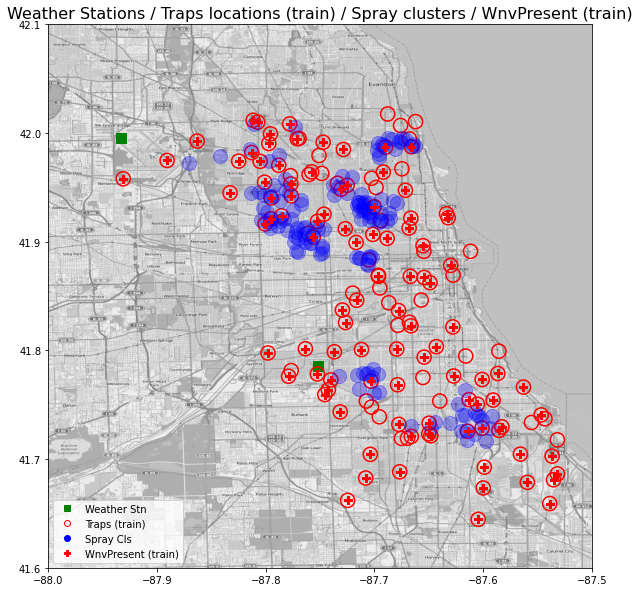

In [ ]:
# getting map data
mapdata = np.loadtxt("assets/mapdata_copyright_openstreetmap_contributors.txt")

# set boundaries
origin = [41.6, -88]              # lat/long of origin (lower left corner)
upperRight = [42.1, -87.5]          # lat/long of upper right corner

# generate plot
plt.figure(figsize=(10,10))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])

# weather stn
for lg, lt in zip(weather_stn['Longitude'], weather_stn['Latitude']):
    plt.scatter(x=lg, y=lt, c='g', marker='s', s=120)

# traps locations
traps_loc = train[['Longitude', 'Latitude']].drop_duplicates(inplace=False)
print(' No of trap locations =', traps_loc.value_counts().sum())
for lg, lt in zip(traps_loc['Longitude'], traps_loc['Latitude']):
    plt.scatter(x=lg, y=lt, marker='o', lw=1.5, facecolors='none', edgecolors='r', s=200)

# DBSCAN clustered spray locations
dbs_spray = rep_points[['Longitude', 'Latitude']]
print(' No of clustered spray locations (100m range) =', dbs_spray.value_counts().sum())
for lg, lt in zip(dbs_spray['Longitude'], dbs_spray['Latitude']):
    plt.scatter(x=lg, y=lt, c='b', marker='o', s=200, alpha=0.3)

# WnvPresent = 1 locations
wnv_present = wnv_present_df[['Longitude', 'Latitude']]
print(' No of unique WnvPresent (train) locations =', wnv_present_df.location.nunique())
for lg, lt in zip(wnv_present['Longitude'], wnv_present['Latitude']):
    plt.scatter(x=lg, y=lt, color='r', marker='P', s=80 )
    
plt.title('Weather Stations / Traps locations (train) / Spray clusters / WnvPresent (train)', fontsize = 16)

#custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='g', marker='s', lw=0, label='Weather Stn'),
                   Line2D([0], [0], color='r', marker='o', lw=0, label='Traps (train)', fillstyle='none'),
                   Line2D([0], [0], color='b', marker='o', lw=0, label='Spray Cls'),
                   Line2D([0], [0], color='r', marker='P', lw=0, label='WnvPresent (train)')]

plt.legend(handles=legend_elements, loc='lower left')

plt.xlim(-88, -87.5)
plt.ylim(41.6, 42.1);

**From above map, we can see clearer that many locations where Wnv was detected (black + symbol) are not even in the spray clusters (blue). Although we can recommend these 'un-spray' locations to the authorities but we are not sure if the cost is too high to bear. As we have not reach the modeling stage, lets do a preliminary cost benefits estimation on the basis of spraying every WnvPresent location (99 locations).**

**To be even more specific, lets also visualize the WnvPresent locations by mosquitos species.**
**Note: these codes are commented out below but feel free to run them for visualization if you wish to.**

### WnvPresent=1 locations by species (where the Wnv carrying species' population were recorded)

In [ ]:
#segregating species where WnvPresent = 1
# wnv_present_df['Species'].value_counts()

In [ ]:
# # no of unique locations where CULEX PIPIENS/RESTUANS is found and WnvPresent=1
# pr_df = wnv_present_df[wnv_present_df['Species']=='CULEX PIPIENS/RESTUANS']
# pr_df.location.nunique()

In [ ]:
# # no of unique locations where CULEX PIPIENS is found and WnvPresent=1
# p_df = wnv_present_df[wnv_present_df['Species']=='CULEX PIPIENS']
# p_df.location.nunique()

In [ ]:
# # no of unique locations where CULEX RESTUANS is found and WnvPresent=1
# r_df = wnv_present_df[wnv_present_df['Species']=='CULEX RESTUANS']
# r_df.location.nunique()

In [ ]:
# # getting map data
# mapdata = np.loadtxt("assets/mapdata_copyright_openstreetmap_contributors.txt")

# # set boundaries
# origin = [41.6, -88]              # lat/long of origin (lower left corner)
# upperRight = [42.1, -87.5]          # lat/long of upper right corner

# # generate plot
# plt.figure(figsize=(10,10))
# plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])

# # weather stn
# for lg, lt in zip(weather_stn['Longitude'], weather_stn['Latitude']):
#     plt.scatter(x=lg, y=lt, c='g', marker='s', s=120)

# # traps locations
# traps_loc = train[['Longitude', 'Latitude']].drop_duplicates(inplace=False)
# print(' No of trap locations =', traps_loc.value_counts().sum())
# for lg, lt in zip(traps_loc['Longitude'], traps_loc['Latitude']):
#     plt.scatter(x=lg, y=lt, marker='o', facecolors='none', edgecolors='r', s=200)

# # DBSCAN clustered spray locations
# dbs_spray = rep_points[['Longitude', 'Latitude']]
# print(' No of clustered spray locations (100m range) =', dbs_spray.value_counts().sum())
# for lg, lt in zip(dbs_spray['Longitude'], dbs_spray['Latitude']):
#     plt.scatter(x=lg, y=lt, c='b', marker='o', s=200, alpha=0.3)

# # WnvPresent = 1 locations by species
# # CULEX PIPIENS/RESTUANS
# pr_wnvpresent = pr_df[['Longitude', 'Latitude']]
# print(' No of CULEX PIPIENS/RESTUANS WnvPresent locations =', pr_df.location.nunique())
# for lg, lt in zip(pr_wnvpresent['Longitude'], pr_wnvpresent['Latitude']):
#     plt.scatter(x=lg, y=lt, c='lime', marker='P', s=80, alpha=0.8)

# # CULEX PIPIENS
# p_wnvpresent = p_df[['Longitude', 'Latitude']]
# print(' No of CULEX PIPIENS WnvPresent locations =', p_df.location.nunique())
# for lg, lt in zip(p_wnvpresent['Longitude'], p_wnvpresent['Latitude']):
#     plt.scatter(x=lg, y=lt, c='cyan', marker='P', s=80, alpha=0.8)

# # CULEX RESTUANS
# r_wnvpresent = r_df[['Longitude', 'Latitude']]
# print(' No of CULEX RESTUANS WnvPresent locations =', r_df.location.nunique())
# for lg, lt in zip(r_wnvpresent['Longitude'], r_wnvpresent['Latitude']):
#     plt.scatter(x=lg, y=lt, c='k', marker='P', s=80, alpha=0.8)

# plt.title('Weather Stations / Traps locations (train) / \n Spray clusters / WnvPresent by Species', fontsize = 16)

# #custom legend
# from matplotlib.lines import Line2D
# legend_elements = [Line2D([0], [0], color='g', marker='s', lw=0, label='Weather Stn'),
#                    Line2D([0], [0], color='r', marker='o', lw=0, label='Traps (train)', fillstyle='none'),
#                    Line2D([0], [0], color='b', marker='o', lw=0, label='Spray Cls'),
#                    Line2D([0], [0], color='lime', marker='P', lw=0, label='CULEX PIPIENS/RESTUANS'),
#                    Line2D([0], [0], color='cyan', marker='P', lw=0, label='CULEX PIPIENS'),
#                    Line2D([0], [0], color='k', marker='P', lw=0, label='CULEX RESTUANS')]

# plt.legend(handles=legend_elements, loc='lower left')

# plt.xlim(-88, -87.5)
# plt.ylim(41.6, 42.1);

## Does spraying reduces number of mosquitos?

**To have a sense of this, we need to determine which location in train data had been sprayed using the location data in spray data. However, there is no exact common coordinates between spray and train data. Thus, we will convert the coordinates into meters and use a 1000m range from the DBSCAN clustered spray locations to determine if a train location had been sprayed. Whether the spray was applied through trucking or a human coverage. It is reasonable to assume a 1000m coverage.**

**To do this we used the Haversine package.**

In [ ]:
import haversine as hs
from haversine import Unit

print('max distance of map (m) :', hs.haversine(origin, upperRight, unit=Unit.METERS))

max distance of map (m) : 69326.66800434075


In [ ]:
# retrieve the DBSCAN clusters centroid
print(dbs_spray.shape)
dbs_spray['location'] = list(zip(dbs_spray.Latitude, dbs_spray.Longitude))
dbs_spray.head(2)

(145, 2)


Longitude   Latitude                               location
0 -88.093767  42.392183  (42.3921833333333, -88.0937666666667)
1 -87.787753  41.979352  (41.9793516666667, -87.7877533333333)

In [ ]:
# mirror a new index to rename as cluster no.
dbs_spray.reset_index(inplace=True)
dbs_spray.head(2)

index  Longitude   Latitude                               location
0      0 -88.093767  42.392183  (42.3921833333333, -88.0937666666667)
1      1 -87.787753  41.979352  (41.9793516666667, -87.7877533333333)

In [ ]:
dbs_spray.rename(columns={'index': 'cluster_no'}, inplace=True)
dbs_spray.head(2)

cluster_no  Longitude   Latitude                               location
0           0 -88.093767  42.392183  (42.3921833333333, -88.0937666666667)
1           1 -87.787753  41.979352  (41.9793516666667, -87.7877533333333)

In [ ]:
# create two temporary base columns to aid calculation
train['nearest_spray_cluster'] = 'no nearest cluster'
train['distance'] = 100000
train.head(2)

Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS    41   N OAK PARK AVE  T002   
1          CULEX RESTUANS    41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   

   NumMosquitos  WnvPresent  Year  Month  Week  Day                location  \
0             1           0  2007      5    22   29  (41.95469, -87.800991)   
1             1           0  2007      5    22   29  (41.95469, -87.800991)   

  nearest_spray_cluster  distance  
0    no nearest cluster    100000  
1    no nearest cluster    100000

In [ ]:
# any train location that is within 1000m from a spray cluster will be considered
range_dist = 1000

# for each spray cluster
for cl_no, dbs_loc in list(zip(dbs_spray['cluster_no'], dbs_spray['location'])):
    result = []
    
    # for each train location
    for index, train_loc in list(zip(train.index, train['location'])):
        
        # calculate distance in meters between spray cluster and train location
        distance = hs.haversine(train_loc, dbs_loc, unit=Unit.METERS)
        
        # anything within 1000m keep
        if distance <= range_dist:
            result.append([cl_no, index, distance])
        else:
            continue
            
    # make a df of all the locations within 1000m from this spray cluster
    result_df = pd.DataFrame(result, columns=['cl_no', 'index', 'distance'])
    # print(result_df)

    # for each kept result 
    for ind, cl, dist in list(zip(result_df['index'], result_df['cl_no'], result_df['distance'])):
        # compare distance with the previously initiated max distance of 100000 (for unclassified locations)
        # using .min() to compare against those that were already updated with a new max distance fro another cluster
        # update nearest cluster and distance
        if dist < train.loc[ind, 'distance'].min():
            train.loc[ind, 'nearest_spray_cluster'] = cl
            train.loc[ind, 'distance'] = dist
        else:
            continue    

In [ ]:
# number of clusters with train locations that are within 1000m of a spray cluster
train['nearest_spray_cluster'].nunique()

32

In [ ]:
# number of train locations that are not within 1000m of a spray cluster ('no nearest cluster') and those that are within
print(train.shape)
train['nearest_spray_cluster'].value_counts()

(10506, 19)


no nearest cluster    7803
102                    414
51                     185
82                     156
4                      139
12                     136
6                      124
2                      117
129                    117
120                    116
143                    116
110                    112
7                      111
85                     104
38                      98
54                      96
106                     92
48                      74
63                      65
9                       50
132                     42
60                      41
3                       31
84                      29
71                      21
112                     21
126                     21
18                      17
97                      15
11                      15
52                      14
135                     14
Name: nearest_spray_cluster, dtype: int64

In [ ]:
# sneek peak
train[['Date', 'Latitude', 'Longitude', 'location', 'nearest_spray_cluster', 'distance']].sample(frac=1).head()

Date   Latitude  Longitude                          location  \
6831 2011-07-25  41.911824 -87.726737  (41.911823999999996, -87.726737)   
5439 2009-08-25  41.954690 -87.800991            (41.95469, -87.800991)   
3463 2007-09-24  41.958271 -87.702575           (41.958271, -87.702575)   
6495 2011-07-11  41.903002 -87.688267   (41.903002, -87.68826700000001)   
4921 2009-07-24  41.906638 -87.701431           (41.906638, -87.701431)   

     nearest_spray_cluster       distance  
6831    no nearest cluster  100000.000000  
5439                    51     819.599988  
3463    no nearest cluster  100000.000000  
6495    no nearest cluster  100000.000000  
4921    no nearest cluster  100000.000000

In [ ]:
# make new df consisting of train locations that are within 1000m of spray cluster
train_spray = train[train['nearest_spray_cluster']!='no nearest cluster']
print(train_spray.shape)
train_spray.head(2)

(2703, 19)


Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS    41   N OAK PARK AVE  T002   
1          CULEX RESTUANS    41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   

   NumMosquitos  WnvPresent  Year  Month  Week  Day                location  \
0             1           0  2007      5    22   29  (41.95469, -87.800991)   
1             1           0  2007      5    22   29  (41.95469, -87.800991)   

  nearest_spray_cluster    distance  
0                    51  819.599988  
1                    51  819.599988

**There are still about 2.7k of spray locations but we are only interested in those locations that fall within the spray dates ranges. This is the only way base on the available data to get a sense of whether spraying helps to reduce mosquitos population.**

In [ ]:
# make new df consisting of only locations that fall within the spray data date range
train_spray_related = train_spray[(train_spray['Date'] >= spray.Date.min()) & (train_spray['Date'] <= spray.Date.max())]
print(train_spray_related.shape)
train_spray_related.head(2)

(660, 19)


Date                                            Address  \
7574 2011-09-01  4100 North Oak Park Avenue, Chicago, IL 60634,...   
7575 2011-09-01  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                     Species Block           Street  Trap  \
7574  CULEX PIPIENS/RESTUANS    41   N OAK PARK AVE  T002   
7575           CULEX PIPIENS    41   N OAK PARK AVE  T002   

                 AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  \
7574  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   
7575  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   

      NumMosquitos  WnvPresent  Year  Month  Week  Day  \
7574            15           0  2011      9    35    1   
7575             7           0  2011      9    35    1   

                    location nearest_spray_cluster    distance  
7574  (41.95469, -87.800991)                    51  819.599988  
7575  (41.95469, -87.800991)                    51  819.599988

In [ ]:
# getting the unique dates where spraying was done and creating year,week,day columns for plotting
unique_spray_dates_df = pd.DataFrame(spray.Date.unique(),columns=['date'])
unique_spray_dates_df = pd.concat([unique_spray_dates_df, unique_spray_dates_df['date'].dt.isocalendar()],axis=1)
unique_spray_dates_df

date  year  week  day
0 2011-08-29  2011    35    1
1 2011-09-07  2011    36    3
2 2013-07-17  2013    29    3
3 2013-07-25  2013    30    4
4 2013-08-08  2013    32    4
5 2013-08-15  2013    33    4
6 2013-08-16  2013    33    5
7 2013-08-22  2013    34    4
8 2013-08-29  2013    35    4
9 2013-09-05  2013    36    4

In [ ]:
# uniques spray date in week for plotting
unique_spray_dates_df['week'].sort_values().unique()

<IntegerArray>
[29, 30, 32, 33, 34, 35, 36]
Length: 7, dtype: UInt32

In [ ]:
# train dates within spray data range in week for plotting
train_spray_related['Week'].sort_values().unique()

array([23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39],
      dtype=int64)

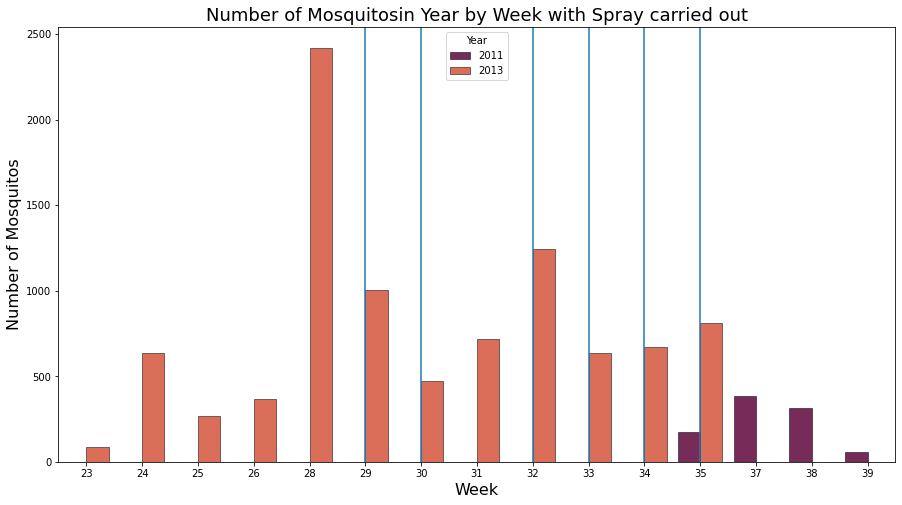

In [ ]:
# plotting overlays
fig, ax = plt.subplots(figsize=(15,8))

sns.barplot(x='Week', y='NumMosquitos', hue='Year', data=train_spray_related, palette='rocket',
edgecolor='black', linewidth=0.5, ci=None, estimator=sum, ax=ax);
plt.title('Number of Mosquitosin Year by Week with Spray carried out', fontsize=18)
plt.xlabel('Week', fontsize=16)
plt.ylabel('Number of Mosquitos', fontsize=16)

for pos, wk in enumerate(train_spray_related['Week'].sort_values().unique()):
    for each in unique_spray_dates_df['week'].sort_values().unique():
        if each == wk:
            ax.axvline(pos);

**We can see that spray data in 2013 was more complete across many weeks whereas 2011 had only data for four weeks. Thus, for the following observations, we will base upon the 2013 data range.**

**The blue lines indicate the dates where spraying was done (in 2013) at the locations that were within 1000m from the clustered spray locations. Spraying is effective only at the location that was covered and appears to be prone to dissipating effect as time goes by.**
- There were sprays carried out on wk 29 and 30 where we can see that the mosquitos population dropped consecutively. However, when there was a pause in wk 31, the population rose considerably.


- From wk 32 when spraying resumed and with continuous sprays over the next few wks, population came down again. The population increase was kept under control despite a slight dissipating effect between wk 33 to 35.


- It should also be noted that these wk numbers had shown to be in the months where mosquitos population rose sharply in earlier analysis. Therefore, frequent spray during this period is definitely necessary.


- As winter colder periods (wk 37-39) kicks in, the mosquitos population started to drop significantly even without spraying. This suggest that cold weather is not condusive for mosquito breeding.


- In the earlier few weeks (wk 23-28) coming out of spring and into summer months, the mosquitos population started to increase. This signaled the need to begin spraying operations at least 4 wks earlier (at wk 23) to prevent a sudden spike in mosquitos population.

**We can also conclude from this image that spraying indeed reduce mosquitos population when done in the right time frame and done continuously.**

# Preliminary Cost Benefits Analysis

## Socio and Economic cost estimates

**As there is no data provided with the data set with regard to the demographics, number of people affected and the extend of their treatment. We performed external research on the internet and found a report that stated: [source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7241786/)**

> There were 1,371 total human WNV cases reported in Illinois from 2005 to 2016. Out of these total reported cases, 906 cases (66%) were from the Chicago region (Cook and DuPage Counties). The number of human WNV cases in the study region varied annually, with the year 2012 reporting the highest number of cases (229) and the lowest number of cases (1) reported in 2009 (Table 2).

![infectno.png](./images/infectno.png "infectno.png")

**Thus, we will base our number of infections on this article's reported figure. That works out to be 1,371 / 12 year = 115 infected persons on average per year.**

**Similarly, as we are not provided with Illinois, Chicago specific economic cost impact due to the virus. We did a search on the internet but was only able to find such costs figures for another US state, Sacramento County, California in 2005. Thus, we shall base our preliminary estimates using figures from this article. [source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/#:~:text=The%20total%20economic%20impact%20of,the%20emergency%20spray%20cost%2Deffective.)**

![cost.png](./images/cost.png "cost.png")


**From the articles, we will use the following metrics. Please refer to the articles for detailed breakdown and composition of each cost item.**

>- Treatment costs per case : USD 33,143
>- Productivity loss per work day missed: USD 191
>- Number of work days missed per case: 50 days

**Using an assumption of 115 persons infected per year:**

>- Total cost of Treatment = 33,143 x 115 = USD 3,811,445 per year
>- Total cost of Productivity loss over 50 days = 191 x 115 x 50 = USD 1,098,250 per year
>- **Total socio-economic loss per year = 3,811,445 + 1,098,250 = USD 4,909,695 per year**

In [ ]:
# saving variable for calculation later
socio_economic_cost = 4909695

## Spray cost estimates

In [ ]:
# locations to spray ie. all unique locations with WnvPresent=1
print('Number of unique locations to spray =', wnv_present_df.location.nunique())

Number of unique locations to spray = 99


![spray_cost](images/spray_cost.png)

In [ ]:
# saving varible for calculation later
cost_per_spray = 261

**A quick search on the internet found that if homeowners engage their own mosquitos control services, it will cost about USD 261 per house in Chicago. It is reasonable to expected that when the Chicago state engages a large scale contractor, the actual cost per house will drastically be lower than this figure that we are using here as a rough basis.**

**From above EDA, we observed that mosquitos population were mostly under control for about a week after a spray. Thus we will infer that only 1 spray is require for each week.**

**Number of unique locations to spray.**
>- 99

**From data we observed that 4 months (July to Oct) per year or 16 wks per year would require spraying.**
>- Total cost of spray over 16 wks period per year = 16 x 99 x 261 = USD 413,424

**All cost expressed as a percentage of socio-economic cost:**
>- **413,424 / 4,909,695 = 8.4%**

**It can be seen from this preliminary analysis that the estimated cost of conducting spray operations weekly across the 16 wks during the historical peak season of Wnv carrying mosquito, is estimated to be 8.4% of the potential socio-economic cost.**

**With the prediction model executing on the test data set and taking into account the weather data's effect on mosquitos population. This cost estimate may very well change so we shall review the cost benefit analysis again after the best prediction model is reveal.**

In [ ]:
# make a helper function for easy calculation
def cba(n_loc, n_weeks):
    cost_spray = round(n_weeks*n_loc*cost_per_spray)
    pct = (cost_spray/socio_economic_cost)*100
    print(f'No of unique locations to spray = {n_loc}')
    print(f'No of weeks to spray            = {n_weeks}')
    
    return cost_spray, round(pct,2)

# Post Modeling Analysis

## When is the peak season for WnvPresent?

In [ ]:
# reading the entire prediction result on test.csv
results = pd.read_csv('assets/test_xgboost_prediction_new.csv')
print(f'Total {results.shape[0]} rows of predictions \n')
results.rename({'id': 'Id',
                'date': 'Date',
                'year':'Year',
                'month': 'Month',
                'week': 'Week',
                'day': 'Day',
                'latitude': 'Latitude',
                'longitude': 'Longitude'}, axis=1, inplace=True)
results.head()

Total 116293 rows of predictions 



Id       Date                 Species  Latitude  Longitude  Tavg  Depart  \
0   1  11/6/2008  CULEX PIPIENS/RESTUANS  41.95469 -87.800991    24       7   
1   2  11/6/2008          CULEX RESTUANS  41.95469 -87.800991    24       7   
2   3  11/6/2008           CULEX PIPIENS  41.95469 -87.800991    24       7   
3   4  11/6/2008        CULEX SALINARIUS  41.95469 -87.800991    24       7   
4   5  11/6/2008         CULEX TERRITANS  41.95469 -87.800991    24       7   

   DewPoint  PrecipTotal  SeaLevel  ...  AvgSpeed_1week  AvgSpeed_2week  \
0        56          0.0     29.99  ...            12.6            9.95   
1        56          0.0     29.99  ...            12.6            9.95   
2        56          0.0     29.99  ...            12.6            9.95   
3        56          0.0     29.99  ...            12.6            9.95   
4        56          0.0     29.99  ...            12.6            9.95   

   r_humidity_1week  r_humidity_2week  Year  Month  Week  Day  xgb_proba  \
0         69.742857         68.670714  2008      6    24   11   0.009922   
1         69.742857         68.670714  2008      6    24   11   0.005913   
2         69.742857         68.670714  2008      6    24   11   0.010365   
3         69.742857         68.670714  2008      6    24   11   0.008353   
4         69.742857         68.670714  2008      6    24   11   0.004982   

   xgb_pred  
0         0  
1         0  
2         0  
3         0  
4         0  

[5 rows x 29 columns]

In [ ]:
# creating a unique location column as helper
results['location'] = list(zip(results.Latitude, results.Longitude))

# filtering for only the months with predicted WnvPresent=1
results = results[results['xgb_pred']==1]
print(f'Number of rows predicted to be WnvPresent=1 = {results.shape[0]}')

Number of rows predicted to be WnvPresent=1 = 6103


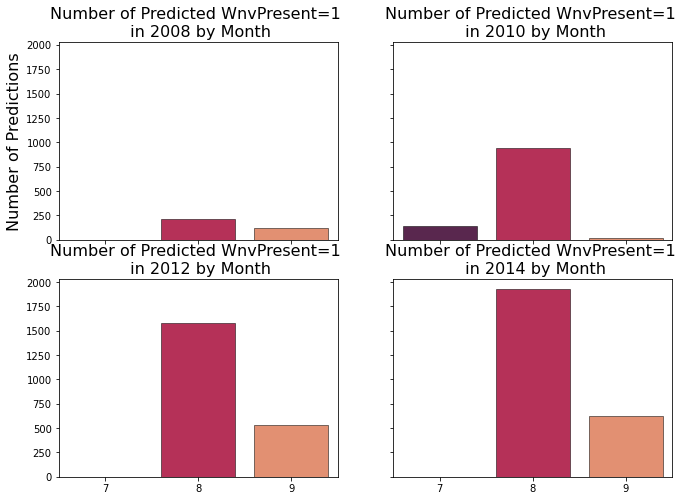

In [ ]:
# visualizing predicted WnvPresent=1 by year by month
preds = results[['Year', 'Month', 'Id']]
order = sorted(preds.Month.unique())

fig, axes = plt.subplots(2,2, figsize=(11,8), facecolor='white', sharex=True, sharey=True)

sns.barplot(x='Month', y='Id',
            data=preds[preds['Year']==2008],
            palette='rocket', edgecolor='black', linewidth=0.5, ci=None, estimator=len, ax=axes[0,0],
            order=order);
axes[0,0].set_title('Number of Predicted WnvPresent=1 \n in 2008 by Month', fontsize=16)
axes[0,0].set_xlabel('', fontsize=16)
axes[0,0].set_ylabel('Number of Predictions', fontsize=16);

sns.barplot(x='Month', y='Id',
            data=preds[preds['Year']==2010],
            palette='rocket', edgecolor='black', linewidth=0.5, ci=None, estimator=len, ax=axes[0,1],
            order=order);
axes[0,1].set_title('Number of Predicted WnvPresent=1 \n in 2010 by Month', fontsize=16)
axes[0,1].set_xlabel('', fontsize=16)
axes[0,1].set_ylabel('', fontsize=16);

sns.barplot(x='Month', y='Id',
            data=preds[preds['Year']==2012],
            palette='rocket', edgecolor='black', linewidth=0.5, ci=None, estimator=len, ax=axes[1,0],
            order=order);
axes[1,0].set_title('Number of Predicted WnvPresent=1 \n in 2012 by Month', fontsize=16)
axes[1,0].set_xlabel('', fontsize=16)
axes[1,0].set_ylabel('', fontsize=16);

sns.barplot(x='Month', y='Id',
            data=preds[preds['Year']==2014],
            palette='rocket', edgecolor='black', linewidth=0.5, ci=None, estimator=len, ax=axes[1,1],
            order=order);
axes[1,1].set_title('Number of Predicted WnvPresent=1 \n in 2014 by Month', fontsize=16)
axes[1,1].set_xlabel('', fontsize=16)
axes[1,1].set_ylabel('', fontsize=16);

In [ ]:
# months with highest distribution of wnvPresent=1
results[results['xgb_pred']==1][['Month', 'Id']].groupby('Month').count()

Id
Month      
7       138
8      4666
9      1299

**It can be seen that across the four prediction years, July to Oct are the months where Wnv was predicted to be present. This matches the EDA findings done on the train data set as well.**

**The months of Aug and Sep saw the highest number of positive predictions. These could be the specific months to target for spraying operations and it again matches the EDA findings done on the train and spray data set.**

In [ ]:
# finding no of unique predicted spray locations
results_coords = results[['Longitude', 'Latitude']].drop_duplicates(inplace=False)
print('No of unique predicted spray locations =', len(results_coords))

No of unique predicted spray locations = 141


## How does the WnvPresent test predictions compare with the train data?

 No of unique WnvPresent (train) locations = 99
 No of unique WnvPresent (test) locations = 141


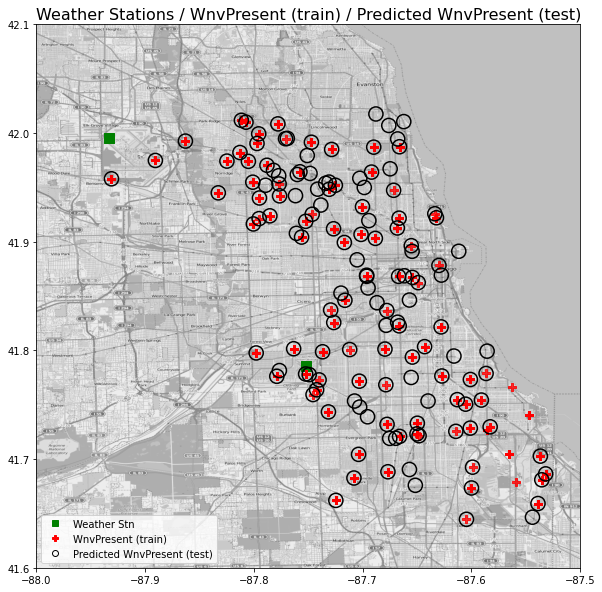

In [ ]:
# getting map data
mapdata = np.loadtxt("assets/mapdata_copyright_openstreetmap_contributors.txt")

# set boundaries
origin = [41.6, -88]              # lat/long of origin (lower left corner)
upperRight = [42.1, -87.5]          # lat/long of upper right corner

# generate plot
plt.figure(figsize=(10,10))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])

# weather stn
for lg, lt in zip(weather_stn['Longitude'], weather_stn['Latitude']):
    plt.scatter(x=lg, y=lt, c='g', marker='s', s=120)

# # traps locations
# traps_loc = train[['Longitude', 'Latitude']].drop_duplicates(inplace=False)
# print(' No of trap locations =', traps_loc.value_counts().sum())
# for lg, lt in zip(traps_loc['Longitude'], traps_loc['Latitude']):
#     plt.scatter(x=lg, y=lt, marker='o', lw=1.5, facecolors='none', edgecolors='r', s=200)

# # DBSCAN clustered spray locations
# dbs_spray = rep_points[['Longitude', 'Latitude']]
# print(' No of clustered spray locations (100m range) =', dbs_spray.value_counts().sum())
# for lg, lt in zip(dbs_spray['Longitude'], dbs_spray['Latitude']):
#     plt.scatter(x=lg, y=lt, c='b', marker='o', s=200, alpha=0.3)

# WnvPresent = 1 locations
wnv_present = wnv_present_df[['Longitude', 'Latitude']]
print(' No of unique WnvPresent (train) locations =', wnv_present_df.location.nunique())
for lg, lt in zip(wnv_present['Longitude'], wnv_present['Latitude']):
    plt.scatter(x=lg, y=lt, c='r', marker='P', s=80, alpha=0.8)
    
# Predicted WnvPresent=1 locations
print(' No of unique WnvPresent (test) locations =', len(results_coords))
for lg, lt in zip(results_coords['Longitude'], results_coords['Latitude']):
    plt.scatter(x=lg, y=lt, marker='o', lw=1.5, s=200, facecolors='none', edgecolors='k')

plt.title('Weather Stations / WnvPresent (train) / Predicted WnvPresent (test)',
          fontsize = 16)

#custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='g', marker='s', lw=0, label='Weather Stn'),
                   #Line2D([0], [0], color='r', marker='o', lw=0, label='Traps (train)', fillstyle='none'),
                   #Line2D([0], [0], color='b', marker='o', lw=0, label='Spray Cls'),
                   Line2D([0], [0], color='r', marker='P', lw=0, label='WnvPresent (train)'),
                   Line2D([0], [0], color='k', marker='o', lw=0, label='Predicted WnvPresent (test)', fillstyle='none')]
 
plt.legend(handles=legend_elements, loc='lower left')

plt.xlim(-88, -87.5)
plt.ylim(41.6, 42.1);

**It should be noted that there are around 10 times more records in test data as compared to train data. Thus, it is possible that the predictions will churn out locations that were not in the train data previously. Vice versa, there are locations in train data but not in test data. This is illustrated in the plot above as well but majority of the predicted WnvPresent locations matched with the actual WnvPresent locations in the train data set.**

## Does continuing with the previous spray locations works?

 No of clustered spray locations (100m range) = 145
 No of unique predicted WnvPresent locations = 141


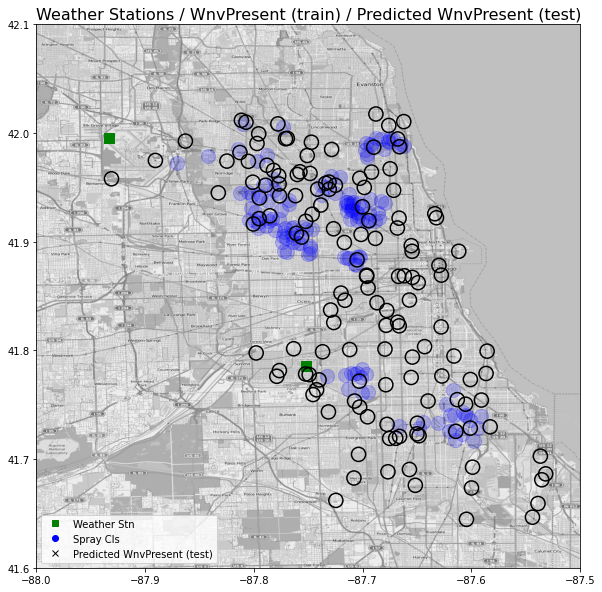

In [ ]:
# getting map data
mapdata = np.loadtxt("assets/mapdata_copyright_openstreetmap_contributors.txt")

# set boundaries
origin = [41.6, -88]              # lat/long of origin (lower left corner)
upperRight = [42.1, -87.5]          # lat/long of upper right corner

# generate plot
plt.figure(figsize=(10,10))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])

# weather stn
for lg, lt in zip(weather_stn['Longitude'], weather_stn['Latitude']):
    plt.scatter(x=lg, y=lt, c='g', marker='s', s=120)

# # traps locations
# traps_loc = train[['Longitude', 'Latitude']].drop_duplicates(inplace=False)
# print(' No of trap locations =', traps_loc.value_counts().sum())
# for lg, lt in zip(traps_loc['Longitude'], traps_loc['Latitude']):
#     plt.scatter(x=lg, y=lt, marker='o', lw=1.5, facecolors='none', edgecolors='r', s=200)

# DBSCAN clustered spray locations
dbs_spray = rep_points[['Longitude', 'Latitude']]
print(' No of clustered spray locations (100m range) =', dbs_spray.value_counts().sum())
for lg, lt in zip(dbs_spray['Longitude'], dbs_spray['Latitude']):
    plt.scatter(x=lg, y=lt, c='b', marker='o', s=200, alpha=0.2)

# # WnvPresent = 1 locations
# wnv_present = wnv_present_df[['Longitude', 'Latitude']]
# print(' No of unique WnvPresent (train) locations =', wnv_present_df.location.nunique())
# for lg, lt in zip(wnv_present['Longitude'], wnv_present['Latitude']):
#     plt.scatter(x=lg, y=lt, c='k', marker='P', s=80, alpha=0.8)
    
# Predicted WnvPresent=1 locations
print(' No of unique predicted WnvPresent locations =', len(results_coords))
for lg, lt in zip(results_coords['Longitude'], results_coords['Latitude']):
    plt.scatter(x=lg, y=lt, marker='o', lw=1.5, s=200, facecolors='none', edgecolors='k')

plt.title('Weather Stations / WnvPresent (train) / Predicted WnvPresent (test)',
          fontsize = 16)

#custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='g', marker='s', lw=0, label='Weather Stn'),
                   #Line2D([0], [0], color='r', marker='o', lw=0, label='Traps (train)', fillstyle='none'),
                   Line2D([0], [0], color='b', marker='o', lw=0, label='Spray Cls'),
                   #Line2D([0], [0], color='k', marker='P', lw=0, label='WnvPresent (train)'),
                   Line2D([0], [0], color='k', marker='x', lw=0, label='Predicted WnvPresent (test)')]
 
plt.legend(handles=legend_elements, loc='lower left')

plt.xlim(-88, -87.5)
plt.ylim(41.6, 42.1);

**We can clearly see from the above plot that if we continue with the past spray clusters, it will not be sufficient to cover the predicted WnvPresent locations. This was also observed with the train data in the EDA section.**

## What are the options and their cost benefits analysis?

**It will not be cost efficient to spray every predicted WnvPresent locations in the four months (Jul to Oct) where Wnv is predicted to be present both in the train and test data set. As such, we shall explore the cost benefits of the following scenarios.**

- Option 1 - Spray all predicted locations for all four months.

- Option 2 - Spray all predicted locations but only for Aug and Sep.

- Option 3 - Spray only predicted locations for each month for all four months.

- Option 4 - Spray only predicted locations for each month but only for Aug and Sep.

### Option 1 - Spray all predicted locations for all four months

In [ ]:
# 4 mths x 4 wks
n_weeks = 4*4

# all predicted locations
n_loc = len(results_coords)
cost_spray, pct = cba(n_loc, n_weeks)
print(f'Cost of spray                   = {cost_spray}')
print(f'As % of socio-economic cost     = {round(pct,2)} %')

No of unique locations to spray = 141
No of weeks to spray            = 16
Cost of spray                   = 588816
As % of socio-economic cost     = 11.99 %


### Option 2 - Spray all predicted locations but only for Aug and Sep

In [ ]:
# 2 mths x 4 wks
n_weeks = 2*4

# all predicted locations
n_loc = len(results_coords)
cost_spray, pct = cba(n_loc, n_weeks)
print(f'Cost of spray                   = {cost_spray}')
print(f'As % of socio-economic cost     = {round(pct,2)} %')

No of unique locations to spray = 141
No of weeks to spray            = 8
Cost of spray                   = 294408
As % of socio-economic cost     = 6.0 %


### Option 3 - Spray only predicted locations for each month for all four months

In [ ]:
sum_cost_spray = 0

# 1 mths x 4 wks
n_weeks = 4

print('JULY')
# only predicted locations for each month
n_loc = len(results[results['Month']==7]['location'].unique())
cost_spray, pct = cba(n_loc, n_weeks)
sum_cost_spray+=cost_spray
print(f'Cost of spray                   = {cost_spray}')
print(f'As % of socio-economic cost     = {round(pct,2)} % \n')

print('AUGUST')
# only predicted locations for each month
n_loc = len(results[results['Month']==8]['location'].unique())
cost_spray, pct = cba(n_loc, n_weeks)
sum_cost_spray+=cost_spray
print(f'Cost of spray                   = {cost_spray}')
print(f'As % of socio-economic cost     = {round(pct,2)} % \n')

print('SEPTEMBER')
# only predicted locations for each month
n_loc = len(results[results['Month']==9]['location'].unique())
cost_spray, pct = cba(n_loc, n_weeks)
sum_cost_spray+=cost_spray
print(f'Cost of spray                   = {cost_spray}')
print(f'As % of socio-economic cost     = {round(pct,2)} % \n')

print('OCTOBER')
# only predicted locations for each month
n_loc = len(results[results['Month']==10]['location'].unique())
cost_spray, pct = cba(n_loc, n_weeks)
sum_cost_spray+=cost_spray
print(f'Cost of spray                   = {cost_spray}')
print(f'As % of socio-economic cost     = {round(pct,2)} % \n')

print('===========================================')
print(f'Total Cost of spray             = {sum_cost_spray}')
print(f'As % of socio-economic cost     = {(sum_cost_spray/socio_economic_cost)*100:.1f} %')

JULY
No of unique locations to spray = 21
No of weeks to spray            = 4
Cost of spray                   = 21924
As % of socio-economic cost     = 0.45 % 

AUGUST
No of unique locations to spray = 138
No of weeks to spray            = 4
Cost of spray                   = 144072
As % of socio-economic cost     = 2.93 % 

SEPTEMBER
No of unique locations to spray = 114
No of weeks to spray            = 4
Cost of spray                   = 119016
As % of socio-economic cost     = 2.42 % 

OCTOBER
No of unique locations to spray = 0
No of weeks to spray            = 4
Cost of spray                   = 0
As % of socio-economic cost     = 0.0 % 

Total Cost of spray             = 285012
As % of socio-economic cost     = 5.8 %


### Option 4 - Spray only predicted locations for each month but only for Aug and Sep

In [ ]:
sum_cost_spray = 0

# 1 mth x 4 wks
n_week = 4

print('AUGUST')
# only predicted locations for each month
n_loc = len(results[results['Month']==8]['location'].unique())
cost_spray, pct = cba(n_loc, n_weeks)
sum_cost_spray+=cost_spray
print(f'Cost of spray                   = {cost_spray}')
print(f'As % of socio-economic cost     = {round(pct,2)} % \n')

print('SEPTEMBER')
n_loc = len(results[results['Month']==9]['location'].unique())
# only predicted locations for each month
cost_spray, pct = cba(n_loc, n_weeks)
sum_cost_spray+=cost_spray
print(f'Cost of spray                   = {cost_spray}')
print(f'As % of socio-economic cost     = {round(pct,2)} % \n')

print('===========================================')
print(f'Total Cost of spray             = {sum_cost_spray}')
print(f'As % of socio-economic cost     = {(sum_cost_spray/socio_economic_cost)*100:.1f} %')

AUGUST
No of unique locations to spray = 138
No of weeks to spray            = 4
Cost of spray                   = 144072
As % of socio-economic cost     = 2.93 % 

SEPTEMBER
No of unique locations to spray = 114
No of weeks to spray            = 4
Cost of spray                   = 119016
As % of socio-economic cost     = 2.42 % 

Total Cost of spray             = 263088
As % of socio-economic cost     = 5.4 %


### Putting all cost together

**Let's put all the cost estimates together for comparison.**

**Preliminary estimation of cost**

    - Total socio-economic loss per year = **USD 4,909,695 per year**
    - Cost of spray (train)              = USD 413,424
    - As % of socio-economic cost        = 8.4%

**Option 1 - Spray all predicted locations for all four months.**

    - Cost of spray                      = USD 588,816
    - As % of socio-economic cost        = 11.99 %
    - Risk estimation                    = Low

**Option 2 - Spray all predicted locations but only Aug and Sep.**

    - Cost of spray                      = USD 294,408
    - As % of socio-economic cost        = 6.0 %
    - Risk estimation                    = Medium

**Option 3 - Spray only predicted locations for each month for all four months.**

    - Total Cost of spray                = USD 285,012
    - As % of socio-economic cost        = 5.8 %
    - Risk estimation                    = Medium

**Option 4 - Spray only predicted locations for each month but only for Aug and Sep.**

    - Total Cost of spray                = USD 263,088
    - As % of socio-economic cost        = 5.4 %
    - Risk estimation                    = High

# Conclusion and Recommendation

Given that human life is at stake and potential escalating socio-economic burden if there are more infections. **Option 1 - Spray all predicted locations for all four months** is predicted to give the **maximum benefits**. This option although is not the cheapest it is estimated to be **ONLY** 11.99% of the potential socio-economic cost. It should be noted that although this option has a cost estimate higher than the preliminary estimate. Our prediction result is based upon test data that is having 10 times more records than train data. From the external research papers, the rate of infection increases when more people are infected and that leads to even higher socio-economic cost.

Option 1 also maximizes the coverage of all predicted WnvPresent locations and ensure consistent and continuous application of sprays. We have seen in the EDA that continuous spraying had a proven effect of keeping mosquitos population in control. By covering all predicted locations, this option also lower the risk of mosquitos changing their breeding hotspots to locations that are not spray.

However, if cost is a major concern to City of Chicago and CPHD, we would recommend **Option 4 - Spray only predicted locations for each month but only for Aug and Sep**. It will be prudent to remind that Option 4 has the highest risk as well.